# Understanding Your New Medical Dataset
## An Interactive Tutorial on Embedding-Based Dataset Exploration


### References & Methods Used
**Embeddings:**
- **BiomedCLIP** - Domain-specific vision-language model for biomedical imaging; 
[🤗 Huggingface](microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224) [Arxiv](https://arxiv.org/pdf/2303.00915)

**Dimensionality Reduction:**
- **PCA** - Principal Component Analysis (classical linear method)
- **t-SNE** - t-distributed Stochastic Neighbor
Embedding; van der Maaten and Hinton 2008 [Paper](https://www.jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)
- **UMAP** - Uniform Manifold Approximation and Projection; McInnes et al. 2018 [Paper](https://arxiv.org/abs/1802.03426)
- **h-NNE** - Hierarchical Nearest Neighbor Embedding; Koulakis and Sarfraz et al. 2022 [Paper](https://openaccess.thecvf.com/content/CVPR2022/papers/Sarfraz_Hierarchical_Nearest_Neighbor_Graph_Embedding_for_Efficient_Dimensionality_Reduction_CVPR_2022_paper.pdf)

**Clustering:**
- **K-means** - Classical centroid-based clustering
- **DBSCAN** - Density-based spatial clustering; Ester et al. 1996 [Paper](https://www.dbs.ifi.lmu.de/Publikationen/Papers/KDD-96.final.frame.pdf)
- **HDBSCAN** - Hierarchical DBSCAN; Campello et al. 2013 [Paper](https://link.springer.com/chapter/10.1007/978-3-642-37456-2_14)
- **FINCH** - Parameter-free hierarchical clustering; Sarfraz et al. [Paper](https://openaccess.thecvf.com/content_CVPR_2019/papers/Sarfraz_Efficient_Parameter-Free_Clustering_Using_First_Neighbor_Relations_CVPR_2019_paper.pdf)

**Other Tools**
- **Duplicate Detection:**
- **Topic Modeling:**

## The Dataset: SLAKE Medical VQA

**SLAKE** is a Semantically-Labeled Knowledge-Enhanced Dataset for Medical Visual Question Answering.

![representative Image](images/Slake_rep.png)




### Overview
- **642 medical images** (CT, MRI, X-ray)
- **14,028 QA pairs** (~22 questions per image)
- **Anatomical locations:** Brain, Chest, Abdomen, etc.
- **Question types:** Modality, anatomy, pathology, reasoning

### Why SLAKE?
- Real-world medical imaging complexity
- Rich metadata (location, modality, question types)
- Perfect for demonstrating embedding-based exploration techniques

### References
**Source:** Liu, Bo, et al. "Slake: A semantically-labeled knowledge-enhanced dataset for medical visual question answering." 2021 IEEE 18th international symposium on biomedical imaging (ISBI). IEEE, 2021.

**Dataset:** [Google Drive Link](https://drive.google.com/file/d/1EZ0WpO5Z6BJUqC3iPBQJJS1INWSMsh7U)




## Setup & Installation

In [1]:
# Install required packages
!pip install -q open-clip-torch torch pillow numpy scikit-learn
!pip install -q hdbscan umap-learn hnne finch-clust
!pip install -q matplotlib seaborn
!pip install -q imagehash  # For duplicate detection
!pip install -q gdown huggingface_hub ipywidgets

In [2]:
# Import libraries
# Additional dependencies: opencv-python, scikit-image
import os
import json
import numpy as np
import time
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Deep learning
import torch
import open_clip
from huggingface_hub import hf_hub_download

# Clustering
from sklearn.cluster import DBSCAN, KMeans
import hdbscan
from finch import FINCH

# Similarity metrics
from sklearn.metrics.pairwise import cosine_similarity

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from hnne import HNNE

# Topic modeling
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Outlier detection
from sklearn.ensemble import IsolationForest

# Import utility functions
import importlib
import utils
importlib.reload(utils)
from utils import (
    compute_ssim, load_modality_labels, filter_cluster_specific_words,load_location_labels, perceptual_hash_duplicates,
                   embedding_similarity_duplicates, select_representative_samples,
                   create_glasbey_colormap)

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


## Download & Load Dataset

In [3]:
# Download SLAKE dataset
dataset_path = Path('./Slake1.0')

if not dataset_path.exists():
    print("Downloading SLAKE dataset...")
    !gdown --fuzzy 'https://drive.google.com/file/d/1EZ0WpO5Z6BJUqC3iPBQJJS1INWSMsh7U/view'
    import zipfile
    with zipfile.ZipFile('Slake1.0.zip', 'r') as zip_ref:
        zip_ref.extractall('.')
    print("Dataset downloaded!")
else:
    print("Dataset already exists!")

Dataset already exists!


In [4]:
# Load dataset structure
def load_slake_dataset(dataset_path):
    """Load SLAKE dataset structure"""
    imgs_path = dataset_path / 'imgs'
    samples = []

    for sample_dir in sorted(imgs_path.iterdir()):
        if not sample_dir.is_dir():
            continue

        source_img = sample_dir / 'source.jpg'
        question_file = sample_dir / 'question.json'

        if source_img.exists() and question_file.exists():
            with open(question_file, 'r') as f:
                qa_data = json.load(f)

            samples.append({
                'sample_id': sample_dir.name,
                'image_path': str(source_img),
                'qa_pairs': qa_data
            })

    return samples

slake_data = load_slake_dataset(dataset_path)
print(f"✓ Loaded {len(slake_data)} samples")
print(f"✓ Sample structure: {list(slake_data[0].keys())}")
print(f"✓ QA pairs per image: ~{len(slake_data[0]['qa_pairs'])}")

✓ Loaded 642 samples
✓ Sample structure: ['sample_id', 'image_path', 'qa_pairs']
✓ QA pairs per image: ~20


## Embedding Extraction with BiomedCLIP

### BiomedCLIP
- **Domain-specific** vision-language model for medical imaging
- Trained on **biomedical image-text pairs**
- **Better performance** than general-purpose CLIP for medical data
- Produces **512-dimensional embeddings**

### What We'll Extract
1. **Image embeddings** (642 images → 642×512)
2. **Text embeddings** (14K QA pairs → 14K×512)


In [5]:
# Load BiomedCLIP model
print("Loading BiomedCLIP model...")

model_path = hf_hub_download(
    repo_id="microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224",
    filename="open_clip_pytorch_model.bin"
)

model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms(
    'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
)
tokenizer = open_clip.get_tokenizer(
    'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
)

model = model.to(device)
model.eval()

print("✓ Model loaded successfully!")
print(f"  Architecture: {model.__class__.__name__}")
print(f"  Input size: {model.visual.image_size if hasattr(model.visual, 'image_size') else '224x224'}")

Loading BiomedCLIP model...
✓ Model loaded successfully!
  Architecture: CustomTextCLIP
  Input size: (224, 224)


In [6]:
# Create embeddings directory
embeddings_dir = Path('./embeddings')
embeddings_dir.mkdir(exist_ok=True)

image_embeddings_path = embeddings_dir / 'image_embeddings.npy'
text_embeddings_path = embeddings_dir / 'text_embeddings.npy'
metadata_path = embeddings_dir / 'metadata.json'

In [7]:
# Generate image embeddings
def generate_image_embeddings(data, model, preprocess, device, batch_size=32):
    """Generate embeddings for all images"""
    embeddings = []

    with torch.no_grad():
        for i in tqdm(range(0, len(data), batch_size), desc="Generating image embeddings"):
            batch = data[i:i+batch_size]

            # Load and process images
            images = []
            for sample in batch:
                img = Image.open(sample['image_path']).convert('RGB')
                img_tensor = preprocess(img)
                images.append(img_tensor)

            # Stack and encode
            images_batch = torch.stack(images).to(device)
            image_features = model.encode_image(images_batch)
            # L2 normalize
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            embeddings.append(image_features.cpu().numpy())

    return np.vstack(embeddings)


In [8]:
# Generate or load
if image_embeddings_path.exists():
    print("Loading cached image embeddings...")
    image_embeddings = np.load(image_embeddings_path)
else:
    print("Generating image embeddings...")
    image_embeddings = generate_image_embeddings(slake_data, model, preprocess_val, device)
    np.save(image_embeddings_path, image_embeddings)
    print("✓ Embeddings saved!")

print(f"\nImage embeddings shape: {image_embeddings.shape}")

Loading cached image embeddings...

Image embeddings shape: (642, 512)


In [9]:
# Generate text embeddings from QA pairs
def generate_text_embeddings(data, model, tokenizer, device, batch_size=32):
    """Generate embeddings for all QA pairs"""
    all_texts = []
    text_to_image_map = []

    for img_idx, sample in enumerate(data):
        for qa in sample['qa_pairs']:
            question = qa.get('question', '')
            answer = qa.get('answer', '')
            text = f"{question} {answer}"
            all_texts.append(text)
            text_to_image_map.append(img_idx)

    embeddings = []

    with torch.no_grad():
        for i in tqdm(range(0, len(all_texts), batch_size), desc="Generating text embeddings"):
            batch_texts = all_texts[i:i+batch_size]
            text_tokens = tokenizer(batch_texts).to(device)
            text_features = model.encode_text(text_tokens)
            # L2 normalize
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            embeddings.append(text_features.cpu().numpy())

    return np.vstack(embeddings), text_to_image_map

In [10]:
# Generate or load
if text_embeddings_path.exists():
    print("Loading cached text embeddings...")
    text_embeddings = np.load(text_embeddings_path)
    with open(metadata_path, 'r') as f:
        metadata = json.load(f)
    text_to_image_map = metadata['text_to_image_map']
else:
    print("Generating text embeddings...")
    text_embeddings, text_to_image_map = generate_text_embeddings(slake_data, model, tokenizer, device)
    np.save(text_embeddings_path, text_embeddings)
    metadata = {'text_to_image_map': text_to_image_map}
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f)
    print("✓ Embeddings saved!")

print(f"\nText embeddings shape: {text_embeddings.shape}")
print(f"QA pairs: {len(text_to_image_map)}")

Loading cached text embeddings...

Text embeddings shape: (14028, 512)
QA pairs: 14028


## First Exploration of the data

### Why Start with PCA?
- **Fast** and **deterministic**
- **Linear** transformation → interpretable
- Good for **initial data exploration**
- Shows **global structure**

### The Experiment 🔍
We'll visualize the same PCA plot **twice**:
1. **Without labels** (all gray) - Can you identify structure?
2. **With anatomical location labels** - Labels reveal hidden patterns!

This demonstrates the **value of ground truth metadata** in understanding embeddings.

### Ground Truth Labels
We'll use **anatomical location** from the dataset metadata as categorical labels:
- Brain, Chest, Abdomen, etc.
- Extracted from `train.json`, `test.json`, `validate.json`


In [11]:
# Load location labels from JSON metadata
labels_dict, location_labels = load_location_labels(dataset_path, slake_data)

# Get unique locations
unique_locations = sorted(set(location_labels))
print(f"✓ Loaded location labels")
print(f"  Unique locations: {unique_locations}")
print(f"  Distribution:")
for loc in unique_locations:
    count = location_labels.count(loc)
    print(f"    {loc}: {count}")

✓ Loaded location labels
  Unique locations: ['Abdomen', 'Brain', 'Brain_Face', 'Brain_Tissue', 'Chest_heart', 'Chest_lung', 'Chest_mediastinal', 'Lung', 'Neck', 'Pelvic Cavity']
  Distribution:
    Abdomen: 170
    Brain: 39
    Brain_Face: 16
    Brain_Tissue: 110
    Chest_heart: 7
    Chest_lung: 19
    Chest_mediastinal: 4
    Lung: 220
    Neck: 16
    Pelvic Cavity: 41


In [12]:
# PCA dimensionality reduction
from sklearn.preprocessing import normalize

X = normalize(image_embeddings, norm='l2')

print("Running PCA...")
pca = PCA(n_components=2, random_state=42)
pca_embeddings = pca.fit_transform(X)
print(f"✓ PCA explained variance: {pca.explained_variance_ratio_.sum():.2%}")

Running PCA...
✓ PCA explained variance: 45.28%


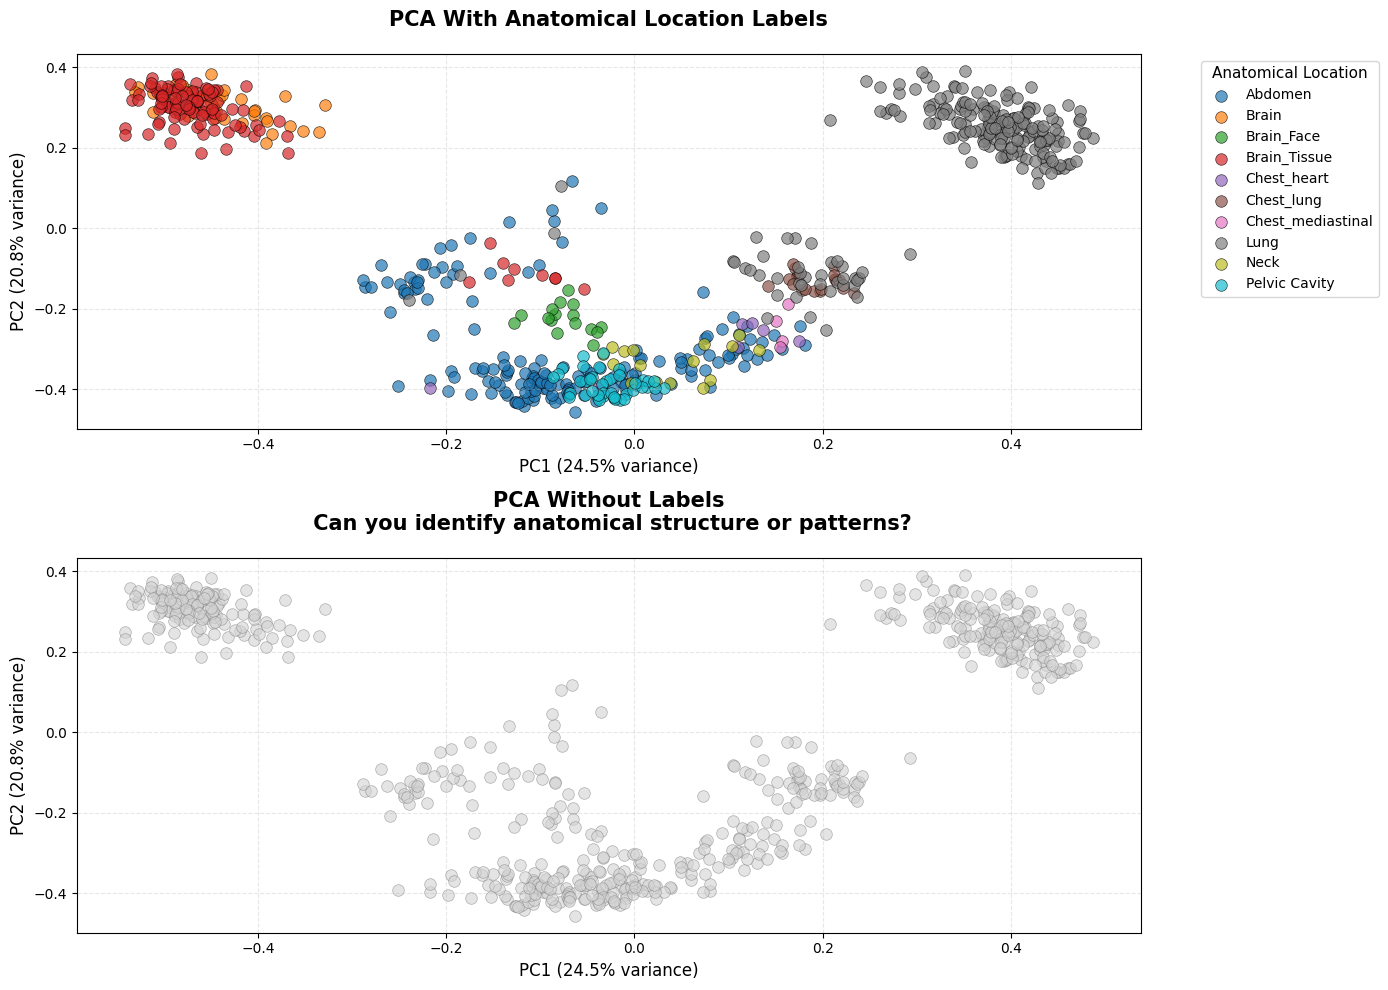


KEY INSIGHTS from PCA Visualization

✗ WITHOUT labels:
  - Hard to interpret what the structure means
  - Unclear which samples belong together
  - Difficult to assess data quality or distribution

✓ WITH anatomical location labels:
  - Clear separation of some anatomical regions
  - Overlap shows embedding similarity across locations
  - Ground truth metadata is INVALUABLE for understanding

Takeaway:
  Always use available metadata to interpret embeddings!
  Labels transform abstract vectors into actionable insights.


In [ ]:
# ENHANCEMENT: Side-by-side comparison (colors OFF vs ON)
glasbey_colors = create_glasbey_colormap(len(unique_locations))
location_to_color = {loc: glasbey_colors[i] for i, loc in enumerate(unique_locations)}

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# ========================================
# Plot 1: WITHOUT COLORS (all gray)
# ========================================
ax = axes[1]
ax.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1],
          c='lightgray', s=70, alpha=0.6, edgecolors='gray', linewidths=0.5)

ax.set_title('PCA Without Labels\n Can you identify anatomical structure or patterns?',
            fontsize=15, fontweight='bold', pad=20)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
ax.grid(True, alpha=0.3, linestyle='--')


# ========================================
# Plot 2: WITH COLORS (anatomical labels)
# ========================================
ax = axes[0]

for loc in unique_locations:
    mask = np.array(location_labels) == loc
    ax.scatter(pca_embeddings[mask, 0], pca_embeddings[mask, 1],
              c=[location_to_color[loc]], s=70, alpha=0.7,
              label=loc, edgecolors='black', linewidths=0.5)

ax.set_title('PCA With Anatomical Location Labels',
            fontsize=15, fontweight='bold', pad=20)
ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)', fontsize=12)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10, 
         title='Anatomical Location', title_fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('plots/pca_color_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*70)
print("KEY INSIGHTS from PCA Visualization")
print("="*70)
print("\n✗ WITHOUT labels:")
print("  - Hard to interpret what the structure means")
print("  - Unclear which samples belong together")
print("  - Difficult to assess data quality or distribution")
print("\n✓ WITH anatomical location labels:")
print("  - Clear separation of some anatomical regions")
print("  - Overlap shows embedding similarity across locations")
print("  - Ground truth metadata is INVALUABLE for understanding")
print("\nTakeaway:")
print("  Always use available metadata to interpret embeddings!")
print("  Labels transform abstract vectors into actionable insights.")
print("="*70)

## Dimensionality Reduction - Runtime Comparison & Scaling

### Methods We'll Compare
1. **PCA** - Linear, fast, global structure
2. **t-SNE** - Non-linear, preserves local structure, slower
3. **UMAP** - Non-linear, balances local & global, faster than t-SNE
4. **h-NNE** - Hierarchical, fast, structure-aware

### Two Questions to Answer:

**Q1: Runtime on Our Dataset** (642 samples)
- Which method is fastest for our specific use case?

**Q2: How Does Runtime Scale?** (100 to 5000 samples)
- What happens with larger datasets?
- Which method remains practical at scale?
- O(n) vs O(n²) vs O(n log n) complexity

This analysis helps you **choose the right method** for your dataset size.


In [14]:
# Runtime comparison
runtimes = {}

# PCA (already computed)
start = time.time()
pca_embeddings = pca.fit_transform(X)
runtimes['PCA'] = time.time() - start

# t-SNE
print("Running t-SNE...")
start = time.time()
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_jobs=-1)
tsne_embeddings = tsne.fit_transform(X)
runtimes['t-SNE'] = time.time() - start
print(f"  Time: {runtimes['t-SNE']:.2f}s")

# UMAP
print("Running UMAP...")
start = time.time()
umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
umap_embeddings = umap_reducer.fit_transform(X)
runtimes['UMAP'] = time.time() - start
print(f"  Time: {runtimes['UMAP']:.2f}s")

# h-NNE
print("Running h-NNE...")
start = time.time()
hnne_reducer = HNNE(n_components=2)
hnne_embeddings = hnne_reducer.fit_transform(X)
runtimes['h-NNE'] = time.time() - start
print(f"  Time: {runtimes['h-NNE']:.2f}s")

print("\n✓ All methods completed!")

Running t-SNE...
  Time: 1.12s
Running UMAP...
  Time: 3.41s
Running h-NNE...
  Time: 0.85s

✓ All methods completed!


In [15]:
# ENHANCEMENT: Scaling analysis with random vectors
print("Running scaling analysis with random vectors...")
print("Testing sizes: 100, 500, 1000, 2000, 5000, 50000, 100000 samples")
print("This may take 2-3 minutes...\n")

from utils import benchmark_dr_scaling

dr_methods_for_benchmark = {
    'PCA': PCA,
    't-SNE': TSNE,
    'UMAP': umap.UMAP,
    'h-NNE': HNNE
}

# Run scaling benchmark
scaling_results, sizes = benchmark_dr_scaling(
    dr_methods_for_benchmark,
    sizes=[100, 500, 1000, 2000,],# 5000, 50000, 100000, 200000],
    dim=512,
    n_components=2,
    n_trials=3
)

print("✓ Scaling analysis complete!")

Running scaling analysis with random vectors...
Testing sizes: 100, 500, 1000, 2000, 5000, 50000, 100000 samples
This may take 2-3 minutes...

✓ Scaling analysis complete!


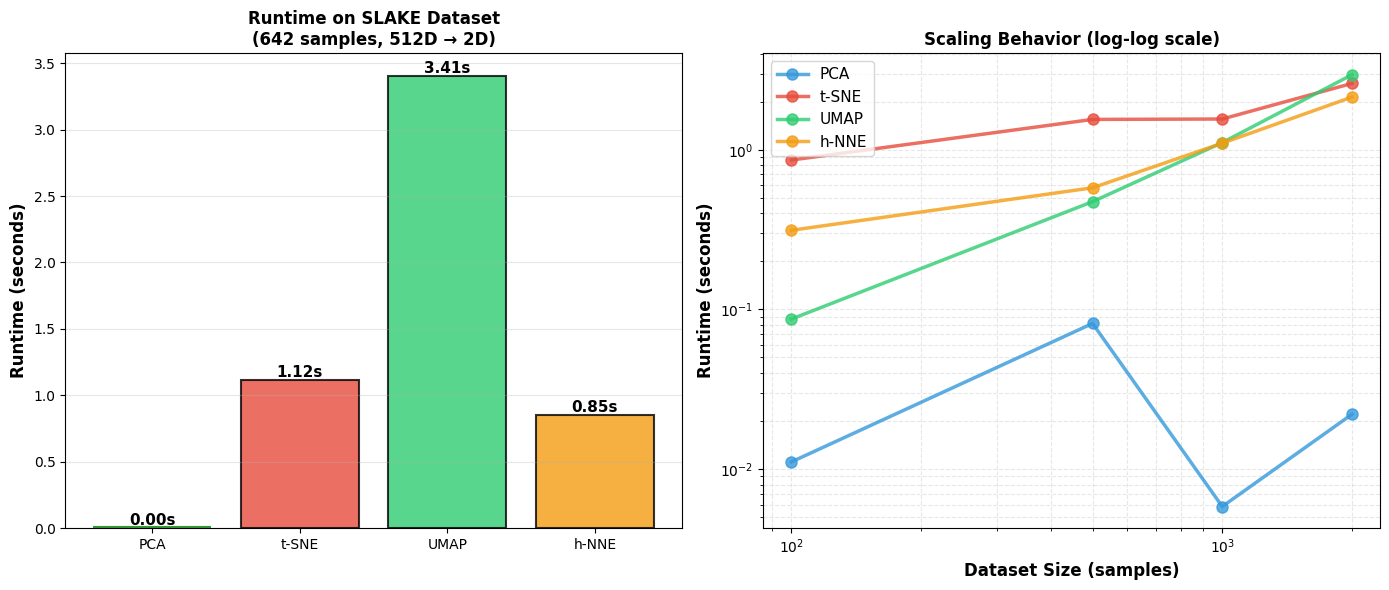


💡 Fastest: PCA | Slowest: UMAP


In [16]:
# Runtime comparison: Actual dataset vs Scaling behavior
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Runtime on actual dataset
ax = axes[0]
methods = list(runtimes.keys())
times = list(runtimes.values())
colors_bar = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

bars = ax.bar(methods, times, color=colors_bar, alpha=0.8, edgecolor='black', linewidth=1.5)
for bar, time_val in zip(bars, times):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{time_val:.2f}s',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_ylabel('Runtime (seconds)', fontsize=12, fontweight='bold')
ax.set_title('Runtime on SLAKE Dataset\n(642 samples, 512D → 2D)', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

fastest_idx = times.index(min(times))
bars[fastest_idx].set_edgecolor('green')
bars[fastest_idx].set_linewidth(3)

# Plot 2: Scaling behavior
ax = axes[1]
method_colors = {'PCA': '#3498db', 't-SNE': '#e74c3c', 'UMAP': '#2ecc71', 'h-NNE': '#f39c12'}

for method_name, method_times in scaling_results.items():
    ax.plot(sizes, method_times, marker='o', linewidth=2.5, markersize=8,
            label=method_name, color=method_colors.get(method_name, 'gray'), alpha=0.8)

ax.set_xlabel('Dataset Size (samples)', fontsize=12, fontweight='bold')
ax.set_ylabel('Runtime (seconds)', fontsize=12, fontweight='bold')
ax.set_title('Scaling Behavior (log-log scale)', fontsize=12, fontweight='bold')
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3, which='both', linestyle='--')
ax.set_xscale('log')
ax.set_yscale('log')

plt.tight_layout()
plt.show()

print(f"\n💡 Fastest: {min(runtimes, key=runtimes.get)} | Slowest: {max(runtimes, key=runtimes.get)}")

## Dimensionality Reduction - Visual Comparison

Now let's compare **how** each method organizes the data spatially.

**What to look for:**
- **Cluster separation:** Are anatomical locations well-separated?
- **Local structure:** Are similar samples grouped together?
- **Global structure:** Is the overall data distribution preserved?


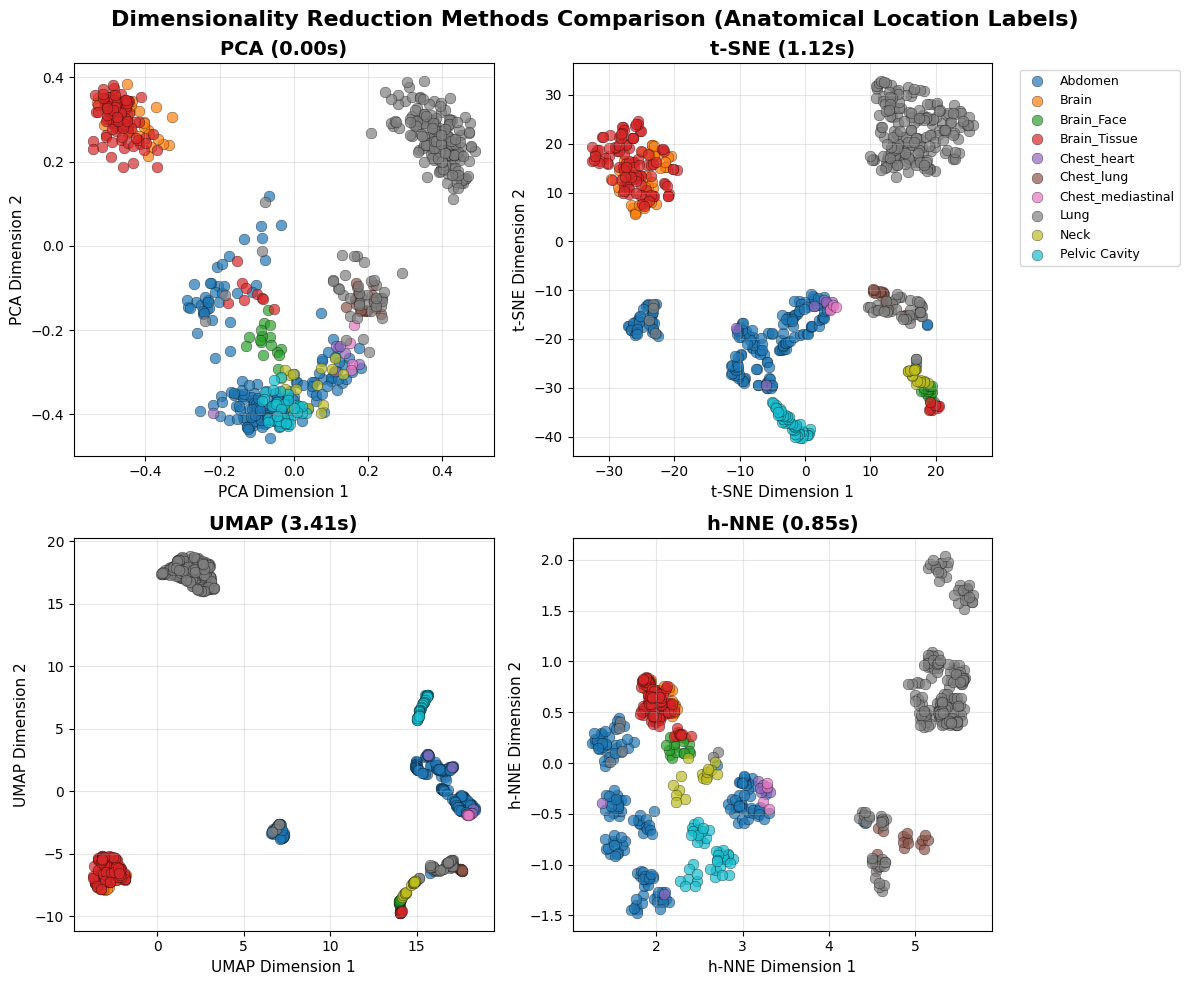


💡 Observations:
  - Which method shows the best anatomical separation?
  - Which preserves local neighborhoods best?
  - Trade-offs between speed and structure preservation?


In [ ]:
# 2x2 grid comparison
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Dimensionality Reduction Methods Comparison (Anatomical Location Labels)',
             fontsize=16, fontweight='bold')

embeddings_list = [
    (pca_embeddings, 'PCA'),
    (tsne_embeddings, 't-SNE'),
    (umap_embeddings, 'UMAP'),
    (hnne_embeddings, 'h-NNE')
]

for idx, (embeddings, method_name) in enumerate(embeddings_list):
    ax = axes[idx // 2, idx % 2]

    for loc in unique_locations:
        mask = np.array(location_labels) == loc
        ax.scatter(embeddings[mask, 0], embeddings[mask, 1],
                  c=[location_to_color[loc]], s=60, alpha=0.7,
                  label=loc, edgecolors='black', linewidths=0.3)

    runtime_str = f" ({runtimes[method_name]:.2f}s)" if method_name in runtimes else ""
    ax.set_title(f'{method_name}{runtime_str}', fontsize=14, fontweight='bold')
    ax.set_xlabel(f'{method_name} Dimension 1', fontsize=11)
    ax.set_ylabel(f'{method_name} Dimension 2', fontsize=11)
    ax.grid(True, alpha=0.3)

    if idx == 1:  # Only show legend for top-right plot
        ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)

plt.tight_layout()
plt.savefig('plots/dr_visual_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 Observations:")
print("  - Which method shows the best anatomical separation?")
print("  - Which preserves local neighborhoods best?")
print("  - Trade-offs between speed and structure preservation?")

## Deep Dive - h-NNE Hierarchical Structure

### What Makes h-NNE Special?
**h-NNE (Hierarchical Nearest Neighbor Embedding)** is unique because:
- 🌳 **Hierarchical:** Captures data structure at multiple scales
- ⚡ **Fast:** Comparable to UMAP, much faster than t-SNE
- 🎯 **Structure-aware:** Preserves both local and hierarchical relationships

### Clustering Side-Effect
h-NNE's hierarchical structure **naturally produces clusters** at different granularity levels.

We'll combine h-NNE with **FINCH** (parameter-free hierarchical clustering) to explore this hierarchy.


In [18]:
# Run FINCH on original embeddings to get hierarchy
print("Running FINCH for hierarchical clustering...")
finch_hierarchy, num_clust, req_c = FINCH(X, verbose=False)

n_levels = finch_hierarchy.shape[1]
print(f"✓ FINCH hierarchy has {n_levels} levels")
print(f"  Clusters per level: {num_clust}")
print(f"  Level 0 (finest): {num_clust[0]} clusters")
print(f"  Level {n_levels-1} (coarsest): {num_clust[-1]} clusters")

Running FINCH for hierarchical clustering...
✓ FINCH hierarchy has 4 levels
  Clusters per level: [161, 40, 12, 3]
  Level 0 (finest): 161 clusters
  Level 3 (coarsest): 3 clusters


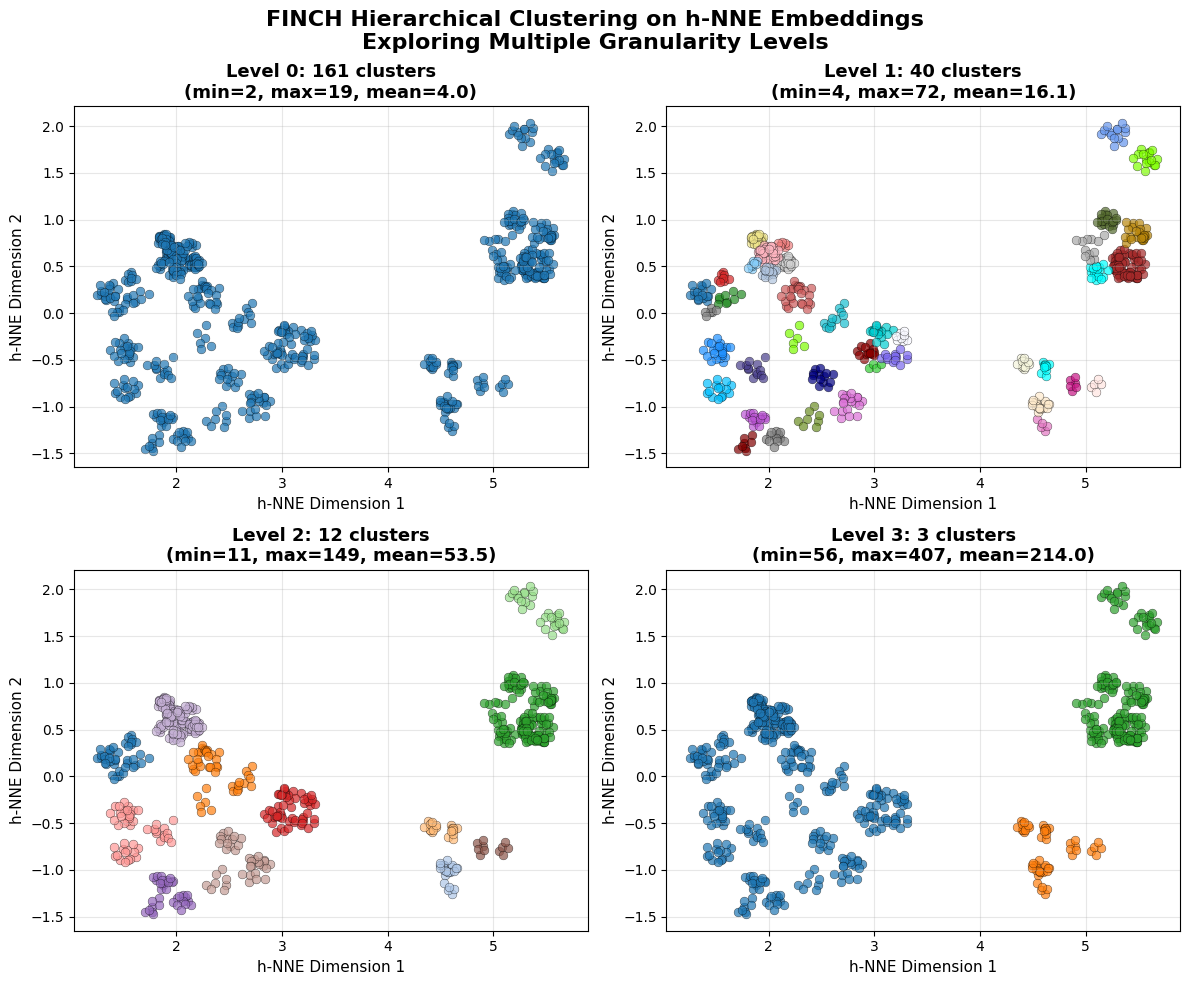


💡 Hierarchical Insights:
  - Fine levels: Many small, specific clusters
  - Coarse levels: Few large, general clusters
  - Hierarchy allows multi-scale data understanding


In [ ]:
# Visualize hierarchy levels on h-NNE embeddings
levels_to_plot = [0, 1, 2, n_levels-1] if n_levels >= 4 else list(range(n_levels))

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('FINCH Hierarchical Clustering on h-NNE Embeddings\nExploring Multiple Granularity Levels',
             fontsize=16, fontweight='bold')

for idx, level in enumerate(levels_to_plot):
    ax = axes[idx // 2, idx % 2]
    labels = finch_hierarchy[:, level]
    n_clusters = len(set(labels))
    unique_labels = sorted(set(labels))

    # Get colors for this level
    level_colors = create_glasbey_colormap(n_clusters)

    for c_idx, label in enumerate(unique_labels):
        mask = labels == label
        ax.scatter(hnne_embeddings[mask, 0], hnne_embeddings[mask, 1],
                  c=[level_colors[c_idx]], s=40, alpha=0.7,
                  edgecolors='black', linewidths=0.3)

    # Compute cluster statistics
    cluster_sizes = [np.sum(labels == l) for l in unique_labels]

    ax.set_title(f'Level {level}: {n_clusters} clusters\n(min={min(cluster_sizes)}, max={max(cluster_sizes)}, mean={np.mean(cluster_sizes):.1f})',
                fontsize=13, fontweight='bold')
    ax.set_xlabel('h-NNE Dimension 1', fontsize=11)
    ax.set_ylabel('h-NNE Dimension 2', fontsize=11)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/hnne_hierarchy_levels.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 Hierarchical Insights:")
print("  - Fine levels: Many small, specific clusters")
print("  - Coarse levels: Few large, general clusters")
print("  - Hierarchy allows multi-scale data understanding")

## How DR Enables Downstream Tasks

### The Power of 2D Visualization

Dimensionality reduction isn't just for pretty plots - it enables **practical dataset analysis**:

```
                    ┌─────────────────────────┐
                    │ Dimensionality Reduction│
                    │      (PCA/t-SNE/        │
                    │      UMAP/h-NNE)        │
                    └───────────┬─────────────┘
                                │
                ┌───────────────┼───────────────┐
                │               │               │
        ┌───────▼──────┐ ┌─────▼──────┐ ┌─────▼──────┐
        │  Duplicate   │ │ Clustering │ │  Outlier   │
        │  Detection   │ │ & Sample   │ │ Detection  │
        │              │ │ Selection  │ │            │
        └──────────────┘ └─────┬──────┘ └────────────┘
                               │
                        ┌──────▼──────┐
                        │Topic Model  │
                        │(Cluster     │
                        │Interpretation)
                        └─────────────┘
```

### Key Applications
1. **Duplicate Detection** - Visual clusters → similar images
2. **Clustering** - Group similar samples for analysis
3. **Sample Selection** - Choose representative samples per cluster
4. **Topic Modeling** - Interpret clusters via QA text analysis
5. **Outlier Detection** - Find anomalous samples
6. **Data Quality** - Assess balance, diversity, coverage

Let's explore each application! 👇


## Duplicate Detection

### Why Detect Duplicates?
- **Data leakage:** Duplicates in train/test splits invalidate evaluation
- **Bias:** Over-representation of certain patterns
- **Efficiency:** Remove redundancy, reduce training time

### Two Approaches

**1. Perceptual Hashing** (Image-based)
- Fast, pixel-level similarity
- Hash function: Image → short binary string
- Similar images → similar hashes (low Hamming distance)

**2. Embedding Similarity** (Semantic)
- Semantic similarity via learned embeddings
- Cosine similarity threshold
- Catches semantic duplicates (e.g., different crops of same scan)

### Visual Inspection 👁️
Beyond algorithmic detection, we'll **visually compare** the most similar pairs to:
- Understand what "similar" really means
- Assess if they're true duplicates or just related
- Evaluate hyperparameter sensitivity


In [20]:
# Method 1: Perceptual hashing
image_paths = [sample['image_path'] for sample in slake_data]

print("Running perceptual hash duplicate detection...")
hash_duplicates = perceptual_hash_duplicates(image_paths, hash_size=8, threshold=5)

print(f"\n✓ Found {len(hash_duplicates)} duplicate groups via hashing")
if hash_duplicates:
    print("\nDuplicate groups:")
    for i, group in enumerate(hash_duplicates[:3]):  # Show first 3
        print(f"  Group {i+1}: {len(group)} images - indices {group}")

Running perceptual hash duplicate detection...

✓ Found 61 duplicate groups via hashing

Duplicate groups:
  Group 1: 94 images - indices [0, 2, 35, 57, 68, 90, 101, 112, 113, 115, 120, 121, 122, 123, 124, 125, 126, 135, 145, 146, 147, 148, 150, 151, 152, 159, 160, 161, 164, 166, 180, 181, 182, 183, 184, 191, 192, 196, 197, 201, 214, 215, 217, 223, 235, 246, 257, 268, 279, 290, 301, 312, 335, 445, 508, 509, 510, 511, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 524, 525, 526, 527, 528, 531, 532, 533, 535, 536, 537, 543, 544, 546, 547, 548, 549, 550, 551, 552, 553, 554, 556, 609, 620, 631]
  Group 2: 2 images - indices [3, 5]
  Group 3: 4 images - indices [4, 22, 209, 635]


In [21]:
# Method 2: Embedding similarity
print("\nRunning embedding-based duplicate detection...")
emb_duplicates = embedding_similarity_duplicates(image_embeddings, threshold=0.98)

print(f"\n✓ Found {len(emb_duplicates)} duplicate groups via embeddings (threshold=0.98)")
if emb_duplicates:
    print("\nDuplicate groups:")
    for i, group in enumerate(emb_duplicates[:3]):  # Show first 3
        print(f"  Group {i+1}: {len(group)} images - indices {group}")


Running embedding-based duplicate detection...

✓ Found 54 duplicate groups via embeddings (threshold=0.98)

Duplicate groups:
  Group 1: 2 images - indices [114, 132]
  Group 2: 2 images - indices [119, 128]
  Group 3: 2 images - indices [138, 139]


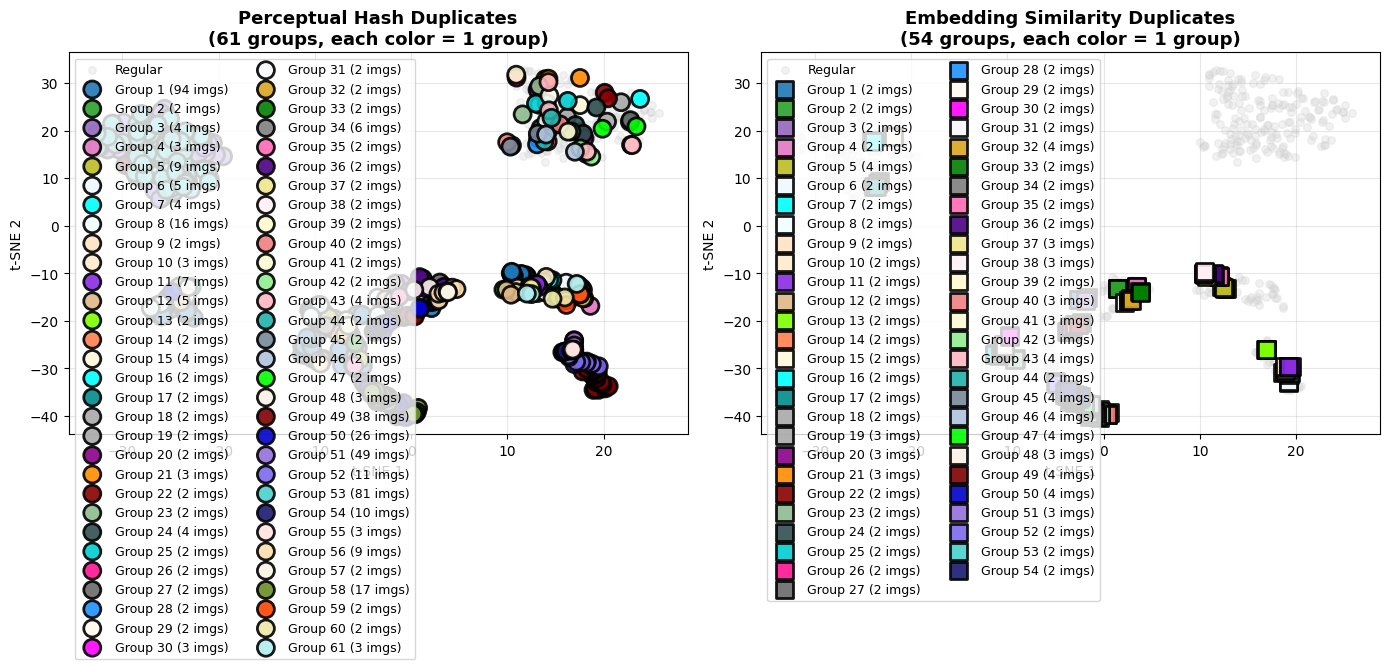


💡 Group Visualization:
  Each color represents ONE duplicate group
  Group size shown in legend
  Helps understand: Are duplicates isolated or clustered together?


In [ ]:
# ENHANCEMENT: Visualize duplicates with COLORED GROUPS
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Hash-based duplicates with colored groups
ax = axes[0]
ax.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1],
          c='lightgray', s=30, alpha=0.3, label='Regular', zorder=1)

if hash_duplicates:
    group_colors = create_glasbey_colormap(len(hash_duplicates))
    for group_idx, group in enumerate(hash_duplicates):
        color = group_colors[group_idx]
        ax.scatter(tsne_embeddings[group, 0], tsne_embeddings[group, 1],
                  s=150, alpha=0.9, c=[color]*len(group),
                  edgecolors='black', linewidths=2,
                  marker='o', label=f'Group {group_idx+1} ({len(group)} imgs)',
                  zorder=2)

ax.set_title(f'Perceptual Hash Duplicates\n({len(hash_duplicates)} groups, each color = 1 group)',
            fontsize=13, fontweight='bold')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.legend(loc='upper left', fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)

# Plot 2: Embedding-based duplicates with colored groups  
ax = axes[1]
ax.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1],
          c='lightgray', s=30, alpha=0.3, label='Regular', zorder=1)

if emb_duplicates:
    group_colors = create_glasbey_colormap(len(emb_duplicates))
    for group_idx, group in enumerate(emb_duplicates):
        color = group_colors[group_idx]
        ax.scatter(tsne_embeddings[group, 0], tsne_embeddings[group, 1],
                  s=150, alpha=0.9, c=[color]*len(group),
                  edgecolors='black', linewidths=2,
                  marker='s', label=f'Group {group_idx+1} ({len(group)} imgs)',
                  zorder=2)

ax.set_title(f'Embedding Similarity Duplicates\n({len(emb_duplicates)} groups, each color = 1 group)',
            fontsize=13, fontweight='bold')
ax.set_xlabel('t-SNE 1')
ax.set_ylabel('t-SNE 2')
ax.legend(loc='upper left', fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/duplicate_detection_colored_groups.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 Group Visualization:")
print(f"  Each color represents ONE duplicate group")
print(f"  Group size shown in legend")
print(f"  Helps understand: Are duplicates isolated or clustered together?")

In [23]:
# ENHANCEMENT: Get similar pairs for duplicate detection
from utils import find_most_similar_pairs, compute_ssim

print("Finding most similar image pairs (embedding-based)...")
similar_pairs_embedding = find_most_similar_pairs(image_embeddings, top_k=10)

# Also get perceptual hash duplicates
print("Finding perceptual hash duplicates...")
hash_similar_pairs = []
if hash_duplicates:
    for group in hash_duplicates[:5]:  # Top 5 groups
        if len(group) >= 2:
            hash_similar_pairs.append((group[0], group[1], 'hash_group'))

print(f"\nTop embedding-based pairs: {len(similar_pairs_embedding)}")
print(f"Perceptual hash groups: {len(hash_similar_pairs)}")

Finding most similar image pairs (embedding-based)...
Finding perceptual hash duplicates...

Top embedding-based pairs: 10
Perceptual hash groups: 5


In [24]:
# Compute SSIM and cosine similarity for all pairs
pairs_with_metrics = []

# Compute metrics for embedding-based pairs
for idx1, idx2, cosine_sim in similar_pairs_embedding[:6]:
    ssim_score = compute_ssim(slake_data[idx1]['image_path'], 
                              slake_data[idx2]['image_path'])
    pairs_with_metrics.append((idx1, idx2, cosine_sim, ssim_score, 'embedding'))

# Add hash pairs with metrics
for item in hash_similar_pairs[:3]:
    if len(item) == 3:
        idx1, idx2, _ = item
        cosine_sim = cosine_similarity(image_embeddings[idx1:idx1+1], 
                                      image_embeddings[idx2:idx2+1])[0][0]
        ssim_score = compute_ssim(slake_data[idx1]['image_path'], 
                                  slake_data[idx2]['image_path'])
        pairs_with_metrics.append((idx1, idx2, cosine_sim, ssim_score, 'hash'))

print(f"Pairs with metrics: {len(pairs_with_metrics)}")

Pairs with metrics: 9


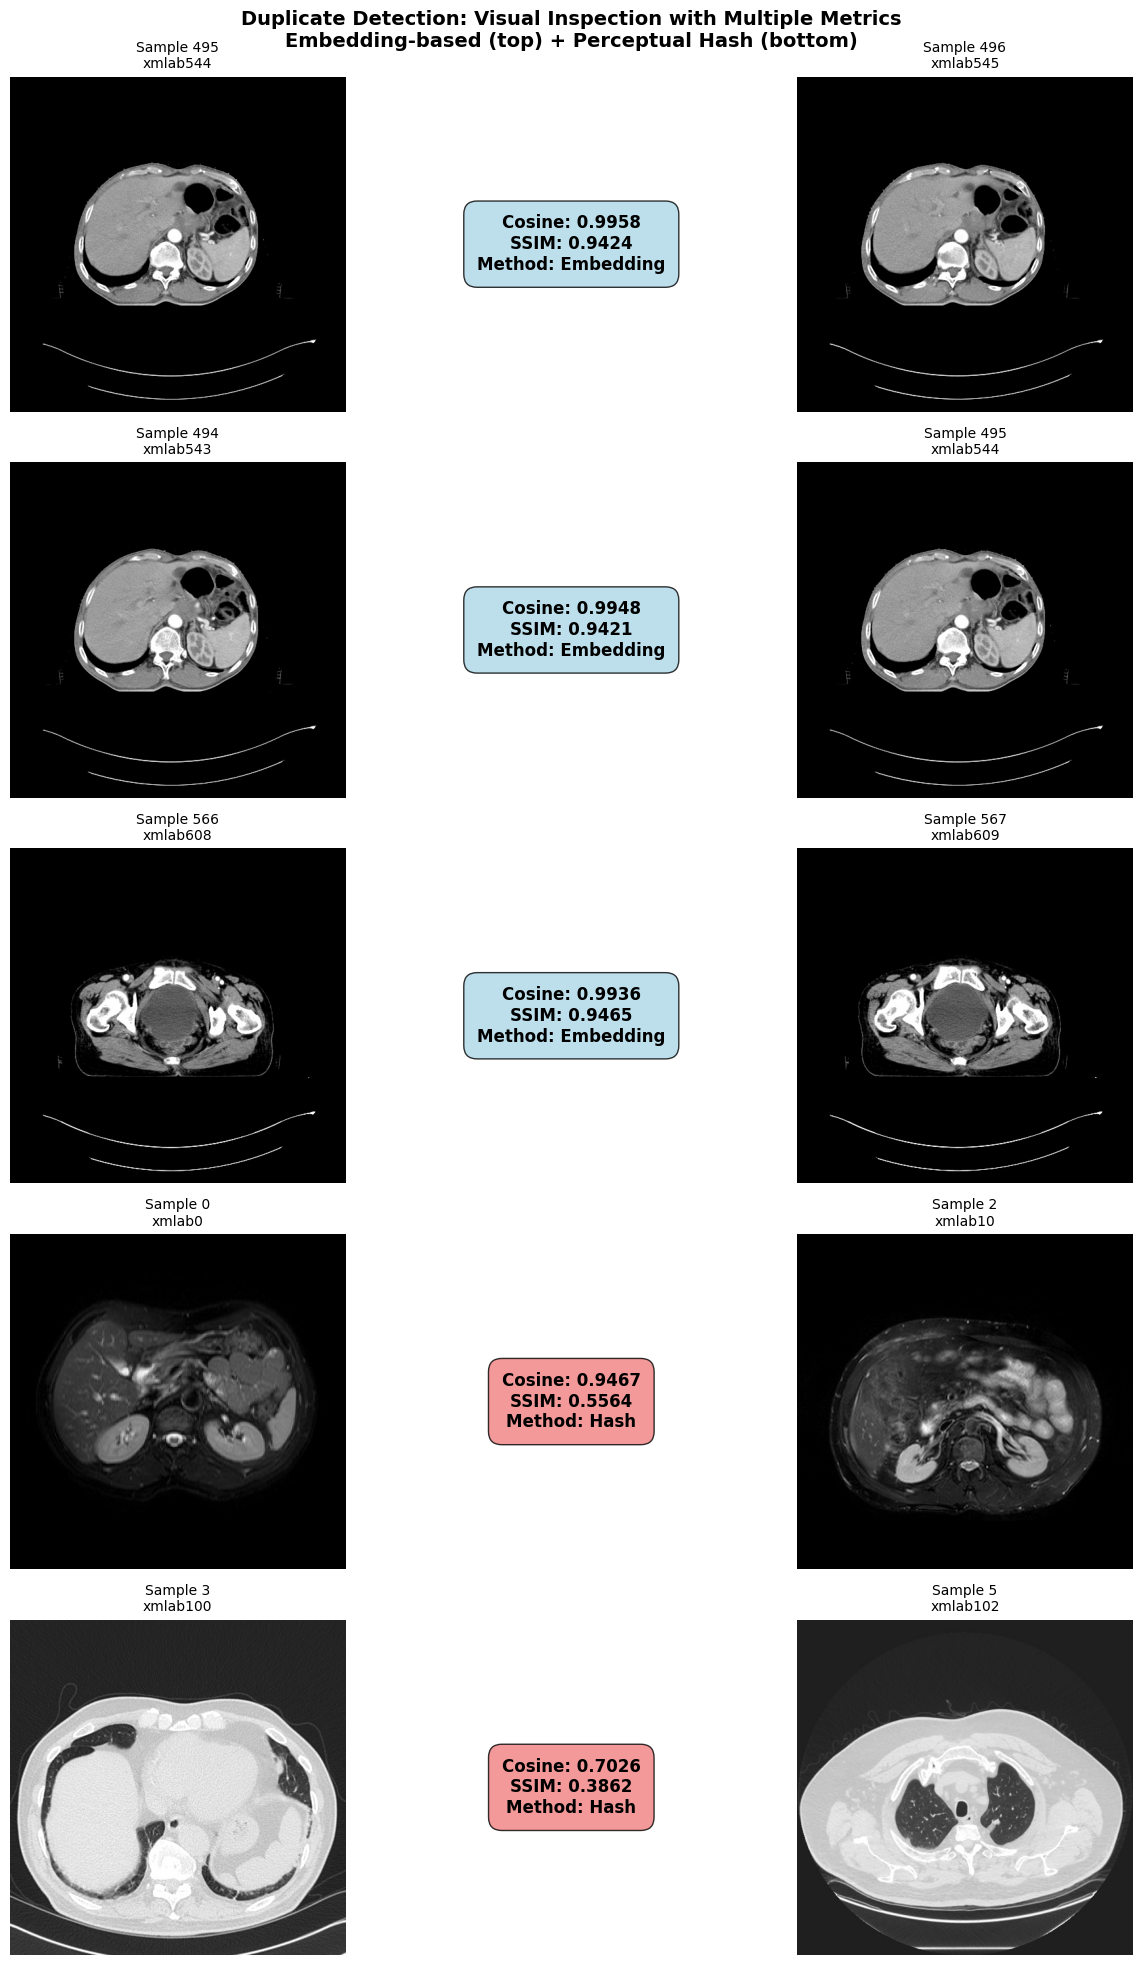


💡 Metrics: Cosine (semantic), SSIM (structural)
   High Cosine + High SSIM = True duplicates
   Embedding-based: semantic; Hash: pixel-level


In [25]:
# Visual comparison with both metrics
n_pairs_to_show = min(3, len([p for p in pairs_with_metrics if p[4] == 'embedding']))
n_hash_to_show = min(2, len([p for p in pairs_with_metrics if p[4] == 'hash']))
total_pairs = n_pairs_to_show + n_hash_to_show

if total_pairs > 0:
    fig, axes = plt.subplots(total_pairs, 3, figsize=(12, 4*total_pairs))
    if total_pairs == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle('Duplicate Detection: Visual Inspection with Multiple Metrics\nEmbedding-based (top) + Perceptual Hash (bottom)',
                 fontsize=14, fontweight='bold')
    
    pair_idx = 0
    
    # Show embedding-based pairs
    for idx1, idx2, cosine_sim, ssim_score, method in pairs_with_metrics:
        if method == 'embedding' and pair_idx < n_pairs_to_show:
            # Left image
            img1 = Image.open(slake_data[idx1]['image_path']).convert('RGB')
            axes[pair_idx, 0].imshow(img1)
            axes[pair_idx, 0].set_title(f"Sample {idx1}\n{slake_data[idx1]['sample_id']}",
                                        fontsize=10)
            axes[pair_idx, 0].axis('off')
            
            # Middle: Metrics
            metrics_text = f"Cosine: {cosine_sim:.4f}\nSSIM: {ssim_score:.4f}\nMethod: Embedding"
            axes[pair_idx, 1].text(0.5, 0.5, metrics_text,
                                  ha='center', va='center', fontsize=12, fontweight='bold',
                                  bbox=dict(boxstyle='round,pad=0.8', facecolor='lightblue', alpha=0.8))
            axes[pair_idx, 1].set_xlim(0, 1)
            axes[pair_idx, 1].set_ylim(0, 1)
            axes[pair_idx, 1].axis('off')
            
            # Right image
            img2 = Image.open(slake_data[idx2]['image_path']).convert('RGB')
            axes[pair_idx, 2].imshow(img2)
            axes[pair_idx, 2].set_title(f"Sample {idx2}\n{slake_data[idx2]['sample_id']}",
                                        fontsize=10)
            axes[pair_idx, 2].axis('off')
            
            pair_idx += 1
    
    # Show hash-based pairs
    for idx1, idx2, cosine_sim, ssim_score, method in pairs_with_metrics:
        if method == 'hash' and pair_idx < total_pairs:
            # Left image
            img1 = Image.open(slake_data[idx1]['image_path']).convert('RGB')
            axes[pair_idx, 0].imshow(img1)
            axes[pair_idx, 0].set_title(f"Sample {idx1}\n{slake_data[idx1]['sample_id']}",
                                        fontsize=10)
            axes[pair_idx, 0].axis('off')
            
            # Middle: Metrics
            metrics_text = f"Cosine: {cosine_sim:.4f}\nSSIM: {ssim_score:.4f}\nMethod: Hash"
            axes[pair_idx, 1].text(0.5, 0.5, metrics_text,
                                  ha='center', va='center', fontsize=12, fontweight='bold',
                                  bbox=dict(boxstyle='round,pad=0.8', facecolor='lightcoral', alpha=0.8))
            axes[pair_idx, 1].set_xlim(0, 1)
            axes[pair_idx, 1].set_ylim(0, 1)
            axes[pair_idx, 1].axis('off')
            
            # Right image
            img2 = Image.open(slake_data[idx2]['image_path']).convert('RGB')
            axes[pair_idx, 2].imshow(img2)
            axes[pair_idx, 2].set_title(f"Sample {idx2}\n{slake_data[idx2]['sample_id']}",
                                        fontsize=10)
            axes[pair_idx, 2].axis('off')
            
            pair_idx += 1
    
    plt.tight_layout()
    plt.show()

print("\n💡 Metrics: Cosine (semantic), SSIM (structural)")
print("   High Cosine + High SSIM = True duplicates")
print("   Embedding-based: semantic; Hash: pixel-level")

## Clustering Methods - Comparison & Benchmarking

### Why Multiple Clustering Methods?
Different algorithms have different **strengths** and **assumptions**:

| Method | Type | Pros | Cons |
|--------|------|------|------|
| **K-means** | Centroid-based | Fast, simple | Needs k, assumes spherical |
| **DBSCAN** | Density-based | Finds noise, arbitrary shapes | Sensitive to parameters |
| **HDBSCAN** | Hierarchical density | Robust, multi-scale | Can label many as noise |
| **FINCH** | Parameter-free | No tuning, hierarchical | May over-cluster |

### Fair Comparison Strategy
For meaningful comparison, we'll match cluster counts:
- **K-means:** 8 clusters (our choice)
- **FINCH:** Find hierarchy level with ~8 clusters
- **HDBSCAN:** Adjust parameters to get ~8 clusters
- **DBSCAN:** Use standard parameters

### Three Analyses:
1. **Runtime comparison** - Which is fastest?
2. **Cluster size distribution** - Balanced vs imbalanced?
3. **Visual structure** - How do they partition the data?


In [26]:
# ENHANCEMENT: Run clustering methods with partition matching
from utils import find_optimal_hierarchy_level
import time

print("Running clustering methods with partition matching...\n")

# Track runtimes
clustering_runtimes = {}

# K-means (target: 8 clusters)
start = time.time()
kmeans = KMeans(n_clusters=8, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X)
clustering_runtimes['K-means'] = time.time() - start
n_clusters_kmeans = 8
print(f"K-means: {n_clusters_kmeans} clusters ({clustering_runtimes['K-means']:.3f}s)")

# FINCH - find level closest to 8 clusters
start = time.time()
finch_hierarchy, num_clust, _ = FINCH(X, verbose=False)
clustering_runtimes['FINCH'] = time.time() - start
optimal_level, optimal_n = find_optimal_hierarchy_level(finch_hierarchy, num_clust, target_n_clusters=8)
finch_labels = finch_hierarchy[:, optimal_level]
n_clusters_finch = optimal_n
print(f"FINCH: {n_clusters_finch} clusters (level {optimal_level}/{len(num_clust)-1}) ({clustering_runtimes['FINCH']:.3f}s)")

# HDBSCAN - try to get ~8 clusters
print("HDBSCAN: Finding parameters for ~8 clusters...")
for min_cluster_size in [20, 25, 30, 35, 40]:
    start = time.time()
    hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=3)
    hdbscan_labels = hdbscan_clusterer.fit_predict(X)
    runtime = time.time() - start
    n_clusters = len(set(hdbscan_labels)) - (1 if -1 in hdbscan_labels else 0)
    if 6 <= n_clusters <= 10:  # Accept 6-10 clusters
        clustering_runtimes['HDBSCAN'] = runtime
        n_clusters_hdbscan = n_clusters
        n_noise_hdbscan = list(hdbscan_labels).count(-1)
        print(f"  → min_cluster_size={min_cluster_size}: {n_clusters} clusters ({runtime:.3f}s) ✓")
        break
else:
    # Fallback
    clustering_runtimes['HDBSCAN'] = runtime
    n_clusters_hdbscan = n_clusters
    n_noise_hdbscan = list(hdbscan_labels).count(-1)
    print(f"  → Using last attempt: {n_clusters} clusters")

# DBSCAN (standard parameters)
start = time.time()
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='euclidean')
dbscan_labels = dbscan.fit_predict(X)
clustering_runtimes['DBSCAN'] = time.time() - start
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise_dbscan = list(dbscan_labels).count(-1)
print(f"DBSCAN: {n_clusters_dbscan} clusters ({clustering_runtimes['DBSCAN']:.3f}s)")

print("\n✓ Clustering complete with matched partitions!")
print(f"  Cluster counts: K-means={n_clusters_kmeans}, FINCH={n_clusters_finch}, HDBSCAN={n_clusters_hdbscan}, DBSCAN={n_clusters_dbscan}")

Running clustering methods with partition matching...

K-means: 8 clusters (0.272s)
FINCH: 12 clusters (level 2/3) (0.008s)
HDBSCAN: Finding parameters for ~8 clusters...
  → min_cluster_size=20: 8 clusters (0.217s) ✓
DBSCAN: 4 clusters (0.049s)

✓ Clustering complete with matched partitions!
  Cluster counts: K-means=8, FINCH=12, HDBSCAN=8, DBSCAN=4


In [27]:
# Clustering runtime scaling benchmark
from utils import benchmark_clustering_methods

print("Running scaling analysis (may take 1-2 min)...")

clustering_methods_bench = {
    'K-means': (KMeans, {'n_clusters': 8, 'random_state': 42}),
    'DBSCAN': (DBSCAN, {'eps': 0.5, 'min_samples': 5}),
    'HDBSCAN': (hdbscan.HDBSCAN, {'min_cluster_size': 5}),
    'FINCH': (None, {})
}

scaling_results_clustering, sizes_clustering = benchmark_clustering_methods(
    clustering_methods_bench,
    sizes=[100, 500, 1000, 2000],
    n_trials=2
)

print("✓ Scaling analysis complete!")

Running scaling analysis (may take 1-2 min)...
✓ Scaling analysis complete!


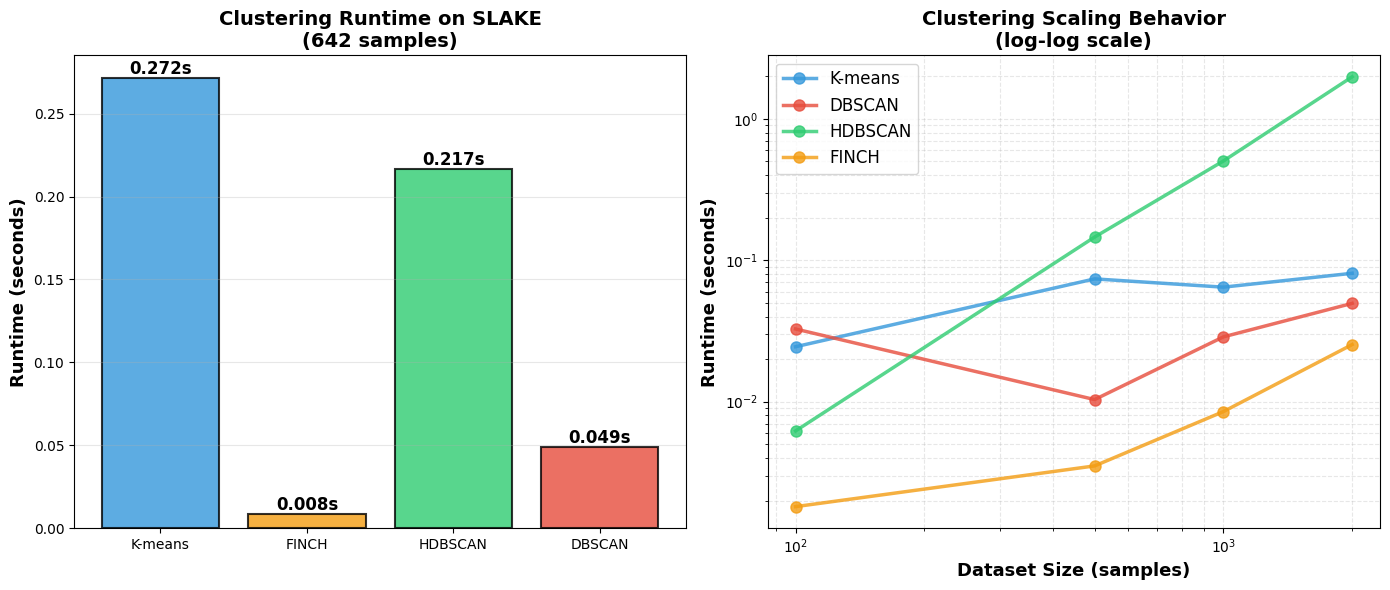


💡 Clustering Runtime Insights:
  Fastest: FINCH (0.008s)
  All methods practical for datasets <5K samples


In [ ]:
# Visualize clustering runtimes
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Runtime on actual dataset
ax = axes[0]
methods = list(clustering_runtimes.keys())
times = list(clustering_runtimes.values())
colors = ['#3498db', '#f39c12', '#2ecc71', '#e74c3c']

bars = ax.bar(methods, times, color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)
for bar, time_val in zip(bars, times):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height, f'{time_val:.3f}s',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Runtime (seconds)', fontsize=13, fontweight='bold')
ax.set_title('Clustering Runtime on SLAKE\n(642 samples)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Plot 2: Scaling behavior
ax = axes[1]
method_colors_scale = {'K-means': '#3498db', 'DBSCAN': '#e74c3c', 'HDBSCAN': '#2ecc71', 'FINCH': '#f39c12'}

for method_name, method_times in scaling_results_clustering.items():
    ax.plot(sizes_clustering, method_times, marker='o', linewidth=2.5, markersize=8,
            label=method_name, color=method_colors_scale.get(method_name, 'gray'), alpha=0.8)

ax.set_xlabel('Dataset Size (samples)', fontsize=13, fontweight='bold')
ax.set_ylabel('Runtime (seconds)', fontsize=13, fontweight='bold')
ax.set_title('Clustering Scaling Behavior\n(log-log scale)', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=12)
ax.grid(True, alpha=0.3, which='both', linestyle='--')
ax.set_xscale('log')
ax.set_yscale('log')

plt.tight_layout()
plt.savefig('plots/clustering_runtime_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 Clustering Runtime Insights:")
fastest = min(clustering_runtimes, key=clustering_runtimes.get)
print(f"  Fastest: {fastest} ({clustering_runtimes[fastest]:.3f}s)")
print(f"  All methods practical for datasets <5K samples")

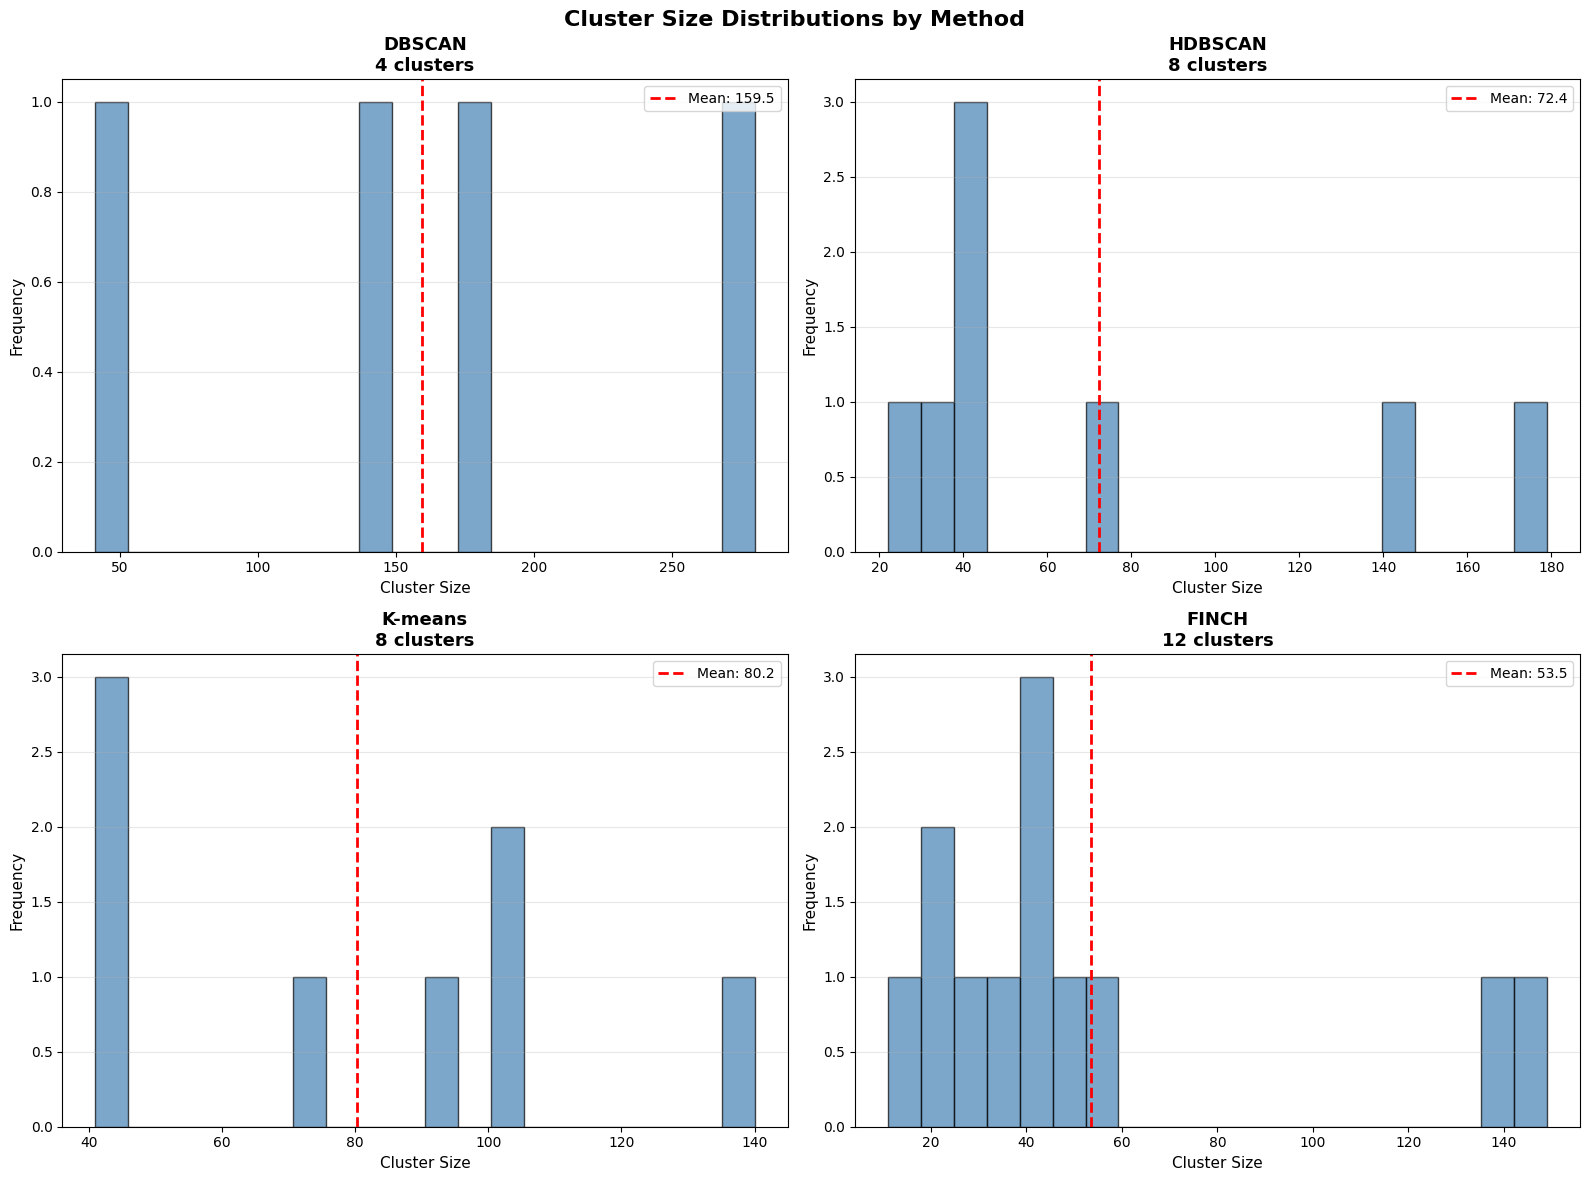


💡 Size Distribution Insights:
  - Balanced vs. imbalanced clusters?
  - Many small clusters or few large ones?
  - Which method matches your analysis goals?


In [ ]:
# Compare cluster size distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Cluster Size Distributions by Method', fontsize=16, fontweight='bold')

clustering_methods = [
    (dbscan_labels, 'DBSCAN', n_clusters_dbscan),
    (hdbscan_labels, 'HDBSCAN', n_clusters_hdbscan),
    (kmeans_labels, 'K-means', n_clusters_kmeans),
    (finch_labels, 'FINCH', n_clusters_finch)
]

for idx, (labels, name, n_clust) in enumerate(clustering_methods):
    ax = axes[idx // 2, idx % 2]

    # Get cluster sizes (exclude noise -1)
    unique_labels = [l for l in set(labels) if l != -1]
    sizes = [np.sum(labels == l) for l in unique_labels]

    ax.hist(sizes, bins=20, color='steelblue', alpha=0.7, edgecolor='black')
    ax.axvline(np.mean(sizes), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(sizes):.1f}')
    ax.set_title(f'{name}\n{n_clust} clusters', fontsize=13, fontweight='bold')
    ax.set_xlabel('Cluster Size', fontsize=11)
    ax.set_ylabel('Frequency', fontsize=11)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('plots/cluster_size_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 Size Distribution Insights:")
print("  - Balanced vs. imbalanced clusters?")
print("  - Many small clusters or few large ones?")
print("  - Which method matches your analysis goals?")

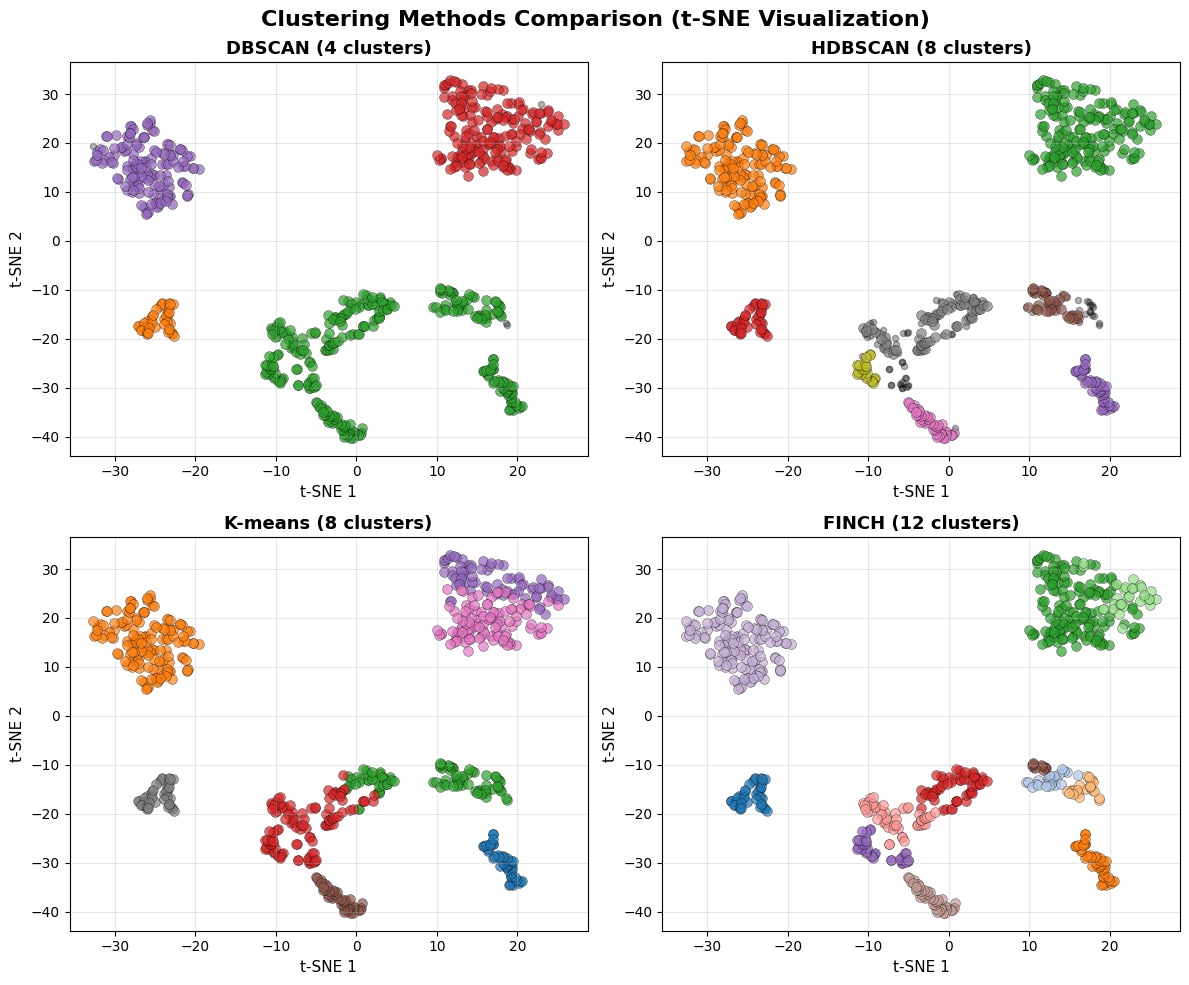

In [ ]:
# Visual comparison on t-SNE
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Clustering Methods Comparison (t-SNE Visualization)', fontsize=16, fontweight='bold')

for idx, (labels, name, n_clust) in enumerate(clustering_methods):
    ax = axes[idx // 2, idx % 2]

    unique_labels = set(labels)
    method_colors = create_glasbey_colormap(len(unique_labels))

    for c_idx, label in enumerate(sorted(unique_labels)):
        mask = labels == label
        if label == -1:
            # Noise in black
            ax.scatter(tsne_embeddings[mask, 0], tsne_embeddings[mask, 1],
                      c='black', s=20, alpha=0.3, label='Noise')
        else:
            ax.scatter(tsne_embeddings[mask, 0], tsne_embeddings[mask, 1],
                      c=[method_colors[c_idx]], s=50, alpha=0.7,
                      edgecolors='black', linewidths=0.3)

    ax.set_title(f'{name} ({n_clust} clusters)', fontsize=13, fontweight='bold')
    ax.set_xlabel('t-SNE 1', fontsize=11)
    ax.set_ylabel('t-SNE 2', fontsize=11)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/clustering_visual_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [31]:
# ENHANCEMENT: Prepare metadata for clustering visualization
from utils import load_modality_labels

# Load modality labels
print("Loading modality labels...")
modality_dict, modality_labels = load_modality_labels(dataset_path, slake_data)

unique_modalities = sorted(set(modality_labels))
print(f"Modalities: {unique_modalities}")

# Prepare clustering methods data
methods_data = [
    (dbscan_labels, 'DBSCAN', n_clusters_dbscan),
    (hdbscan_labels, 'HDBSCAN', n_clusters_hdbscan),
    (kmeans_labels, 'K-means', n_clusters_kmeans),
    (finch_labels, 'FINCH', n_clusters_finch)
]

# Create color mappings
location_colors_map = {loc: glasbey_colors[i] for i, loc in enumerate(unique_locations)}
modality_colors = create_glasbey_colormap(len(unique_modalities))
modality_colors_map = {mod: modality_colors[i] for i, mod in enumerate(unique_modalities)}

Loading modality labels...
Modalities: ['CT', 'MRI', 'X-Ray']


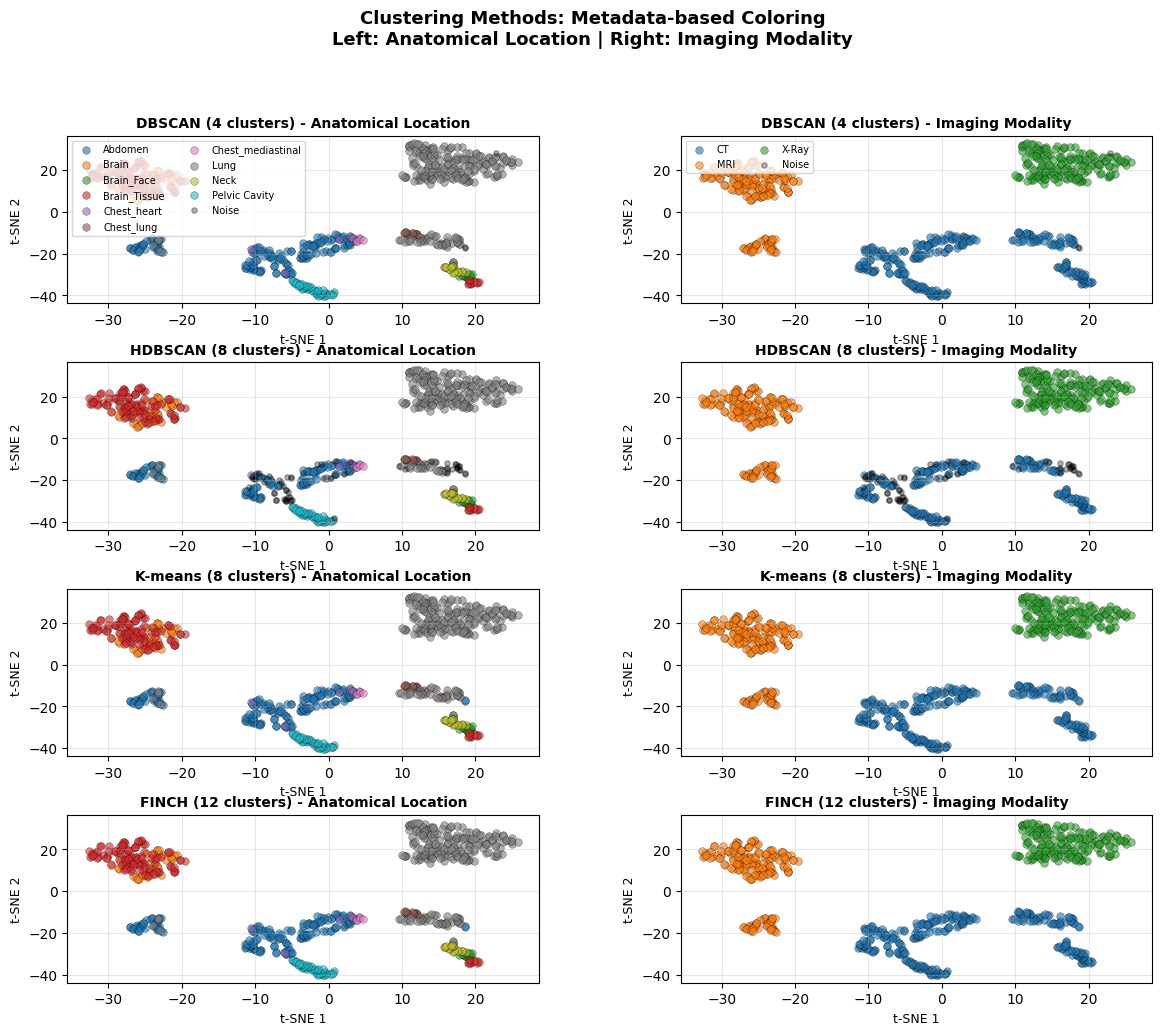


💡 Do clusters align with anatomy or modality?


In [32]:
# Clustering colored by metadata: 4×2 grid
fig = plt.figure(figsize=(14, 11))
gs = fig.add_gridspec(4, 2, hspace=0.35, wspace=0.3)

for method_idx, (labels, method_name, n_clust) in enumerate(methods_data):
    # Left column: colored by anatomical location
    ax = fig.add_subplot(gs[method_idx, 0])
    
    for loc in unique_locations:
        loc_mask = np.array(location_labels) == loc
        # Filter by this clustering method (exclude noise)
        if -1 in labels:
            valid_mask = loc_mask & (labels != -1)
        else:
            valid_mask = loc_mask
            
        if np.any(valid_mask):
            ax.scatter(tsne_embeddings[valid_mask, 0], tsne_embeddings[valid_mask, 1],
                      c=[location_colors_map[loc]], s=30, alpha=0.6,
                      label=loc if method_idx == 0 else None,
                      edgecolors='black', linewidths=0.3)
    
    # Plot noise points in black
    if -1 in labels:
        noise_mask = labels == -1
        ax.scatter(tsne_embeddings[noise_mask, 0], tsne_embeddings[noise_mask, 1],
                  c='black', s=15, alpha=0.3, label='Noise' if method_idx == 0 else None)
    
    ax.set_title(f'{method_name} ({n_clust} clusters) - Anatomical Location',
                fontsize=10, fontweight='bold')
    ax.set_xlabel('t-SNE 1', fontsize=9)
    ax.set_ylabel('t-SNE 2', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    if method_idx == 0:
        ax.legend(loc='upper left', fontsize=7, ncol=2)
    
    # Right column: colored by modality
    ax = fig.add_subplot(gs[method_idx, 1])
    
    for mod in unique_modalities:
        mod_mask = np.array(modality_labels) == mod
        # Filter by this clustering method (exclude noise)
        if -1 in labels:
            valid_mask = mod_mask & (labels != -1)
        else:
            valid_mask = mod_mask
            
        if np.any(valid_mask):
            ax.scatter(tsne_embeddings[valid_mask, 0], tsne_embeddings[valid_mask, 1],
                      c=[modality_colors_map[mod]], s=30, alpha=0.6,
                      label=mod if method_idx == 0 else None,
                      edgecolors='black', linewidths=0.3)
    
    # Plot noise points
    if -1 in labels:
        noise_mask = labels == -1
        ax.scatter(tsne_embeddings[noise_mask, 0], tsne_embeddings[noise_mask, 1],
                  c='black', s=15, alpha=0.3, label='Noise' if method_idx == 0 else None)
    
    ax.set_title(f'{method_name} ({n_clust} clusters) - Imaging Modality',
                fontsize=10, fontweight='bold')
    ax.set_xlabel('t-SNE 1', fontsize=9)
    ax.set_ylabel('t-SNE 2', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    if method_idx == 0:
        ax.legend(loc='upper left', fontsize=7, ncol=2)

fig.suptitle('Clustering Methods: Metadata-based Coloring\nLeft: Anatomical Location | Right: Imaging Modality',
             fontsize=13, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n💡 Do clusters align with anatomy or modality?")

## Sample-Level Analysis - All Methods & Hierarchies

### Deep Dive: One Sample Across All Clusterings

Let's pick **one sample** and see how different methods cluster it:

**Question:** Does the same sample belong to the same "group" across methods?

### What We'll Show:
- **All 4 base methods:** DBSCAN, HDBSCAN, K-means, FINCH
- **FINCH hierarchy:** Multiple levels (finest → coarsest)
- **Grid visualization:** 2×3 layout showing all perspectives

### Why This Matters:
- **Method disagreement** reveals algorithmic assumptions
- **FINCH hierarchy** shows multi-scale structure
- **Helps choose** the right clustering for your task

This demonstrates that **clustering is not absolute** - it depends on the algorithm and parameters!


In [33]:
# ENHANCEMENT: Analyze one sample across ALL methods and FINCH hierarchy
sample_idx = np.random.randint(0, len(slake_data))
sample_id = slake_data[sample_idx]['sample_id']

print(f"Selected sample: {sample_id} (index {sample_idx})")
print(f"  Location: {location_labels[sample_idx]}")
print(f"\nCluster assignments:")
print(f"  DBSCAN:   cluster {dbscan_labels[sample_idx]}")
print(f"  HDBSCAN:  cluster {hdbscan_labels[sample_idx]}")
print(f"  K-means:  cluster {kmeans_labels[sample_idx]}")
print(f"  FINCH L0: cluster {finch_hierarchy[sample_idx, 0]} (finest)")
if len(num_clust) > 1:
    print(f"  FINCH L1: cluster {finch_hierarchy[sample_idx, 1]}")
if len(num_clust) > 2:
    print(f"  FINCH L2: cluster {finch_hierarchy[sample_idx, 2]} (coarsest)")

# Prepare all clustering methods for visualization
methods_labels = {
    'DBSCAN': dbscan_labels,
    'HDBSCAN': hdbscan_labels,
    'K-means': kmeans_labels,
    'FINCH L0': finch_hierarchy[:, 0],
}

# Add FINCH hierarchy levels
if len(num_clust) > 1:
    methods_labels['FINCH L1'] = finch_hierarchy[:, 1]
if len(num_clust) > 2:
    methods_labels['FINCH L2'] = finch_hierarchy[:, 2]

print(f"\n✓ Will visualize {len(methods_labels)} clustering perspectives")

Selected sample: xmlab79 (index 619)
  Location: Brain

Cluster assignments:
  DBSCAN:   cluster 3
  HDBSCAN:  cluster 0
  K-means:  cluster 1
  FINCH L0: cluster 126 (finest)
  FINCH L1: cluster 27
  FINCH L2: cluster 9 (coarsest)

✓ Will visualize 6 clustering perspectives


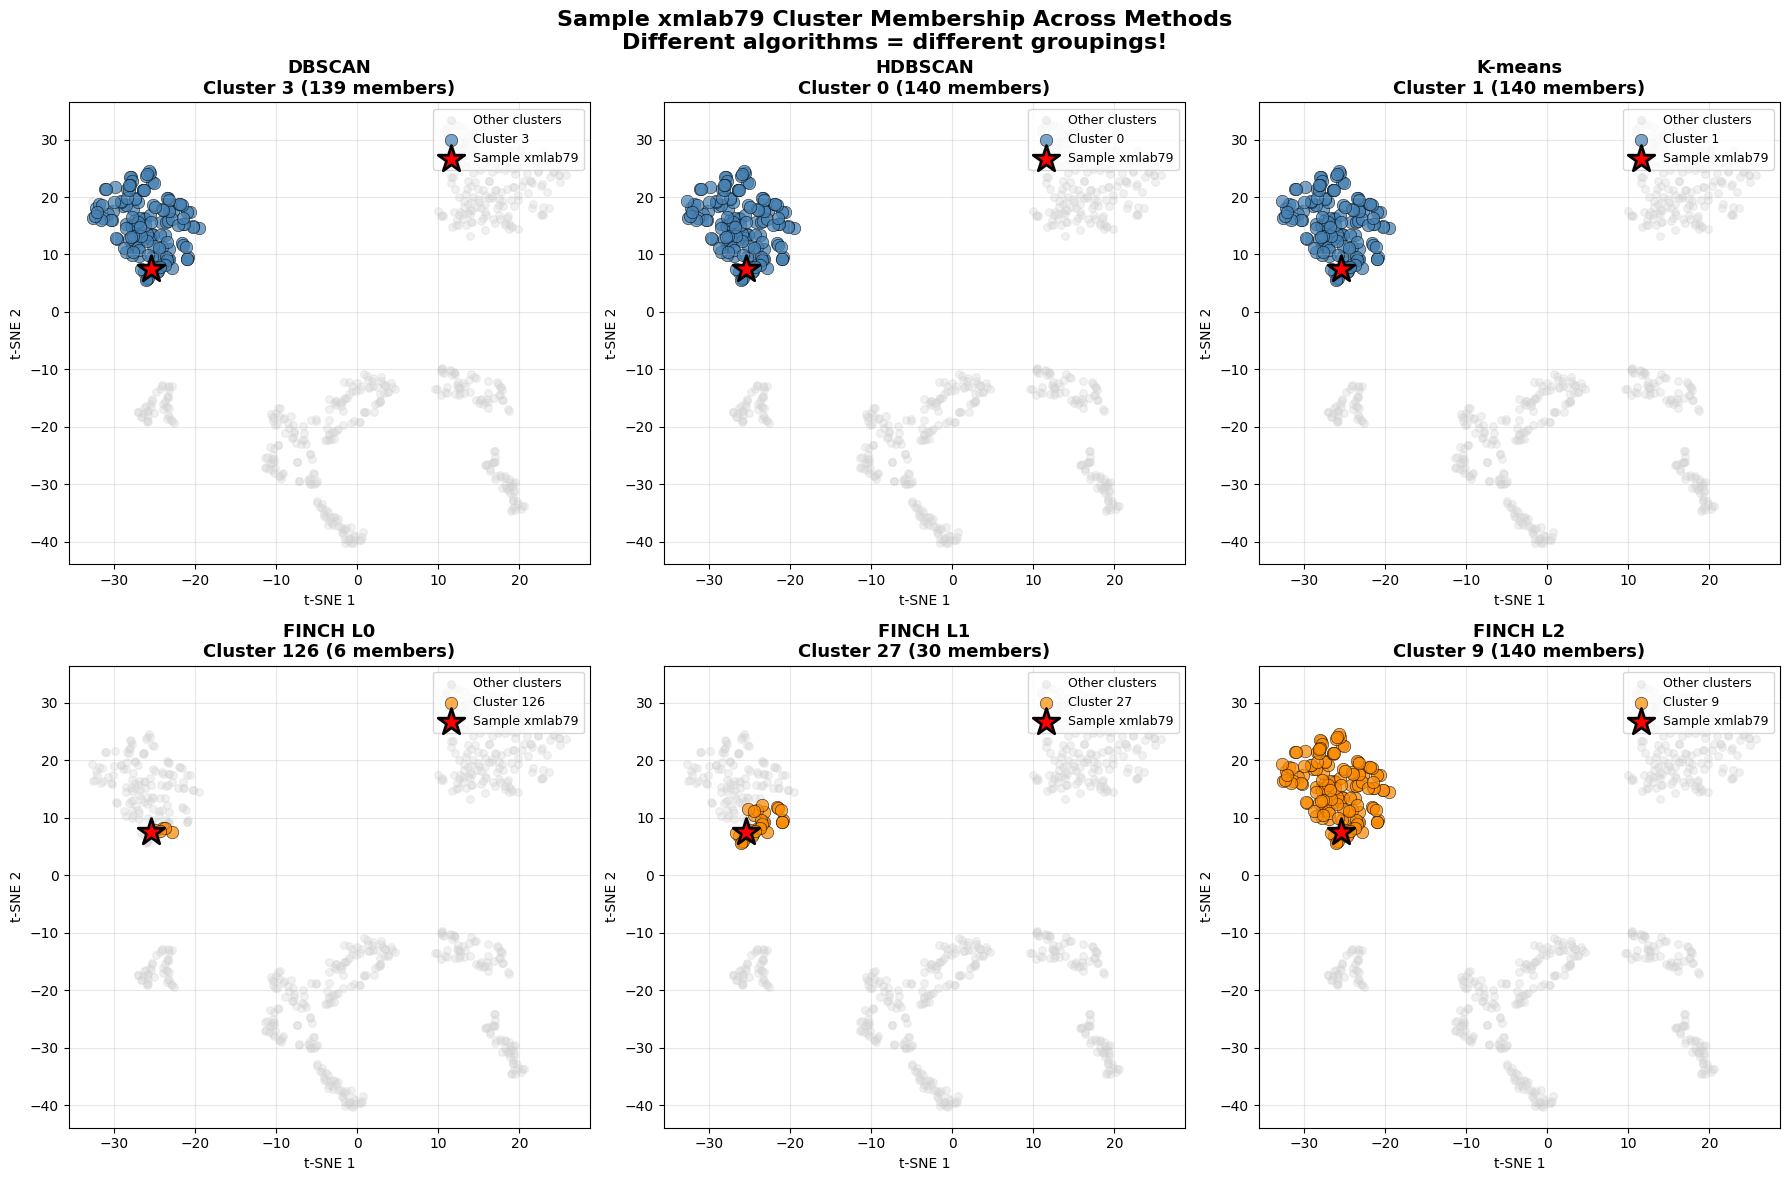


💡 INSIGHTS: Method Comparison

This sample (xmlab79) is grouped differently by each method:
  • DBSCAN:   Cluster 3 with 139 members
  • HDBSCAN:  Cluster 0 with 140 members
  • K-means:  Cluster 1 with 140 members
  • FINCH:    Different groupings at different hierarchy levels

🎯 Key Takeaways:
  1. Clustering is NOT absolute - depends on algorithm choice
  2. Density methods (DBSCAN/HDBSCAN) may label samples as noise
  3. Hierarchical methods (FINCH) show multi-scale structure
  4. Choose method based on your specific goals and assumptions


In [ ]:
# Grid visualization: All methods + FINCH hierarchy
n_methods = len(methods_labels)
n_cols = 3
n_rows = (n_methods + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)
axes = axes.flatten()

fig.suptitle(f'Sample {sample_id} Cluster Membership Across Methods\nDifferent algorithms = different groupings!',
             fontsize=16, fontweight='bold')

for idx, (method_name, labels) in enumerate(methods_labels.items()):
    ax = axes[idx]
    
    sample_cluster = labels[sample_idx]
    cluster_mask = labels == sample_cluster
    n_in_cluster = np.sum(cluster_mask)
    
    # Plot all samples in light gray
    ax.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1],
              c='lightgray', s=30, alpha=0.3, label='Other clusters')
    
    # Highlight the cluster this sample belongs to
    cluster_color = 'steelblue' if 'FINCH' not in method_name else 'darkorange'
    ax.scatter(tsne_embeddings[cluster_mask, 0], tsne_embeddings[cluster_mask, 1],
              c=cluster_color, s=80, alpha=0.7,
              label=f'Cluster {sample_cluster}', edgecolors='black', linewidths=0.5)
    
    # Highlight the selected sample with a star
    ax.scatter(tsne_embeddings[sample_idx:sample_idx+1, 0],
              tsne_embeddings[sample_idx:sample_idx+1, 1],
              c='red', s=400, marker='*', label=f'Sample {sample_id}',
              edgecolors='black', linewidths=2, zorder=10)
    
    # Title with cluster info
    if sample_cluster == -1:
        title_text = f'{method_name}\nNoise (outlier)'
    else:
        title_text = f'{method_name}\nCluster {sample_cluster} ({n_in_cluster} members)'
    
    ax.set_title(title_text, fontsize=13, fontweight='bold')
    ax.set_xlabel('t-SNE 1', fontsize=10)
    ax.set_ylabel('t-SNE 2', fontsize=10)
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

# Hide extra subplots
for idx in range(len(methods_labels), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('plots/sample_level_all_methods.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("💡 INSIGHTS: Method Comparison")
print("="*80)
print(f"\nThis sample ({sample_id}) is grouped differently by each method:")
print(f"  • DBSCAN:   {'Noise/Outlier' if dbscan_labels[sample_idx] == -1 else f'Cluster {dbscan_labels[sample_idx]} with {np.sum(dbscan_labels == dbscan_labels[sample_idx])} members'}")
print(f"  • HDBSCAN:  {'Noise/Outlier' if hdbscan_labels[sample_idx] == -1 else f'Cluster {hdbscan_labels[sample_idx]} with {np.sum(hdbscan_labels == hdbscan_labels[sample_idx])} members'}")
print(f"  • K-means:  Cluster {kmeans_labels[sample_idx]} with {np.sum(kmeans_labels == kmeans_labels[sample_idx])} members")
print(f"  • FINCH:    Different groupings at different hierarchy levels")

print("\n🎯 Key Takeaways:")
print("  1. Clustering is NOT absolute - depends on algorithm choice")
print("  2. Density methods (DBSCAN/HDBSCAN) may label samples as noise")
print("  3. Hierarchical methods (FINCH) show multi-scale structure")
print("  4. Choose method based on your specific goals and assumptions")
print("="*80)

## Slide 12: Sample Selection Strategies Comparison

### The Challenge
You have 642 images, but you need to select a **representative subset** for:
- Manual annotation/labeling
- Creating a validation set
- Showing examples in presentations
- Active learning iterations

### Question: How to Select?

Different strategies optimize for different goals:

| Strategy | Goal | Pros | Cons | Best For |
|----------|------|------|------|----------|
| **Random** | Baseline | Unbiased, simple | May miss rare patterns | Large datasets, baselines |
| **Stratified** | Cluster coverage | Ensures all clusters represented | Requires clustering | Balanced representation |
| **Diversity** | Distribution coverage | Covers data distribution well | Computationally expensive | Active learning, annotation |
| **Boundary** | Decision boundaries | Informative for classifiers | May include outliers | Training ML models |

### We'll Compare All 4!
Visualize each strategy's selections on the same t-SNE plot and assess coverage.


In [35]:
# Run all 4 sample selection strategies
from utils import (select_samples_random, select_samples_stratified,
                   select_representative_samples, select_samples_boundary)

n_samples_target = 50  # Target number of samples to select
samples_per_cluster = 5  # For cluster-based methods

print("Running 4 sample selection strategies...")
print(f"Target: ~{n_samples_target} samples\n")

# Strategy 1: Random
random_indices = select_samples_random(n_samples_target, len(slake_data), random_state=42)
print(f"1. Random: {len(random_indices)} samples selected")

# Strategy 2: Stratified (equal per cluster)
stratified_indices = select_samples_stratified(kmeans_labels, samples_per_cluster=samples_per_cluster)
print(f"2. Stratified: {len(stratified_indices)} samples selected ({samples_per_cluster} per cluster)")

# Strategy 3: Diversity-based (centroid + diverse)
diversity_indices = select_representative_samples(kmeans_labels, image_embeddings, 
                                                   samples_per_cluster=samples_per_cluster)
print(f"3. Diversity: {len(diversity_indices)} samples selected (representative + diverse)")

# Strategy 4: Boundary-based (near cluster boundaries)
boundary_indices = select_samples_boundary(kmeans_labels, image_embeddings,
                                           samples_per_cluster=samples_per_cluster)
print(f"4. Boundary: {len(boundary_indices)} samples selected (near decision boundaries)")

# Store all strategies
strategies = {
    'Random': random_indices,
    'Stratified': stratified_indices,
    'Diversity': diversity_indices,
    'Boundary': boundary_indices
}

print(f"\n✓ All strategies complete!")

Running 4 sample selection strategies...
Target: ~50 samples

1. Random: 50 samples selected
2. Stratified: 40 samples selected (5 per cluster)
3. Diversity: 40 samples selected (representative + diverse)
4. Boundary: 40 samples selected (near decision boundaries)

✓ All strategies complete!


In [36]:
# ENHANCEMENT: Prepare styling for sample selection strategies
strategy_styles = {
    'Random': {'color': '#3498db', 'marker': 'o', 'size': 120},
    'Stratified': {'color': '#2ecc71', 'marker': 's', 'size': 120},
    'Diversity': {'color': '#e74c3c', 'marker': 'D', 'size': 120},
    'Boundary': {'color': '#f39c12', 'marker': '^', 'size': 120}
}

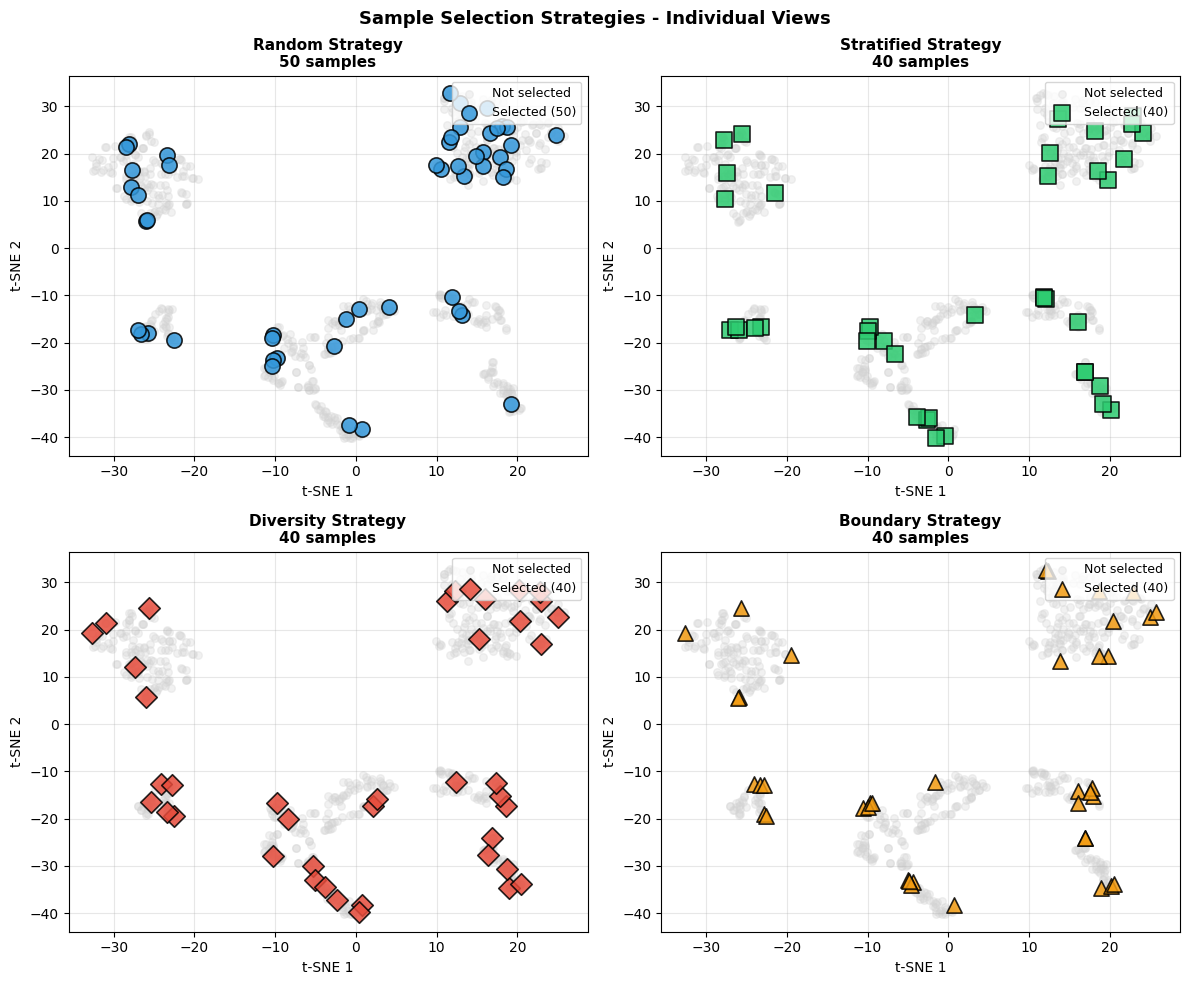


📊 Individual Coverage:
  Random: 50 samples
  Stratified: 40 samples
  Diversity: 40 samples
  Boundary: 40 samples


In [37]:
# Part 1: Individual strategy visualizations (2×2 grid)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, (strategy_name, selected_indices) in enumerate(strategies.items()):
    ax = axes[idx]
    style = strategy_styles[strategy_name]
    
    # Plot all samples in light gray
    ax.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1],
              c='lightgray', s=30, alpha=0.3, label='Not selected', zorder=1)
    
    # Highlight selected samples for this strategy
    ax.scatter(tsne_embeddings[selected_indices, 0],
              tsne_embeddings[selected_indices, 1],
              c=style['color'], marker=style['marker'], s=style['size'],
              alpha=0.85, label=f"Selected ({len(selected_indices)})",
              edgecolors='black', linewidths=1.2, zorder=2)
    
    ax.set_title(f'{strategy_name} Strategy\n{len(selected_indices)} samples',
                fontsize=11, fontweight='bold')
    ax.set_xlabel('t-SNE 1', fontsize=10)
    ax.set_ylabel('t-SNE 2', fontsize=10)
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

fig.suptitle('Sample Selection Strategies - Individual Views',
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n📊 Individual Coverage:")
for strategy_name, selected_indices in strategies.items():
    print(f"  {strategy_name}: {len(selected_indices)} samples")

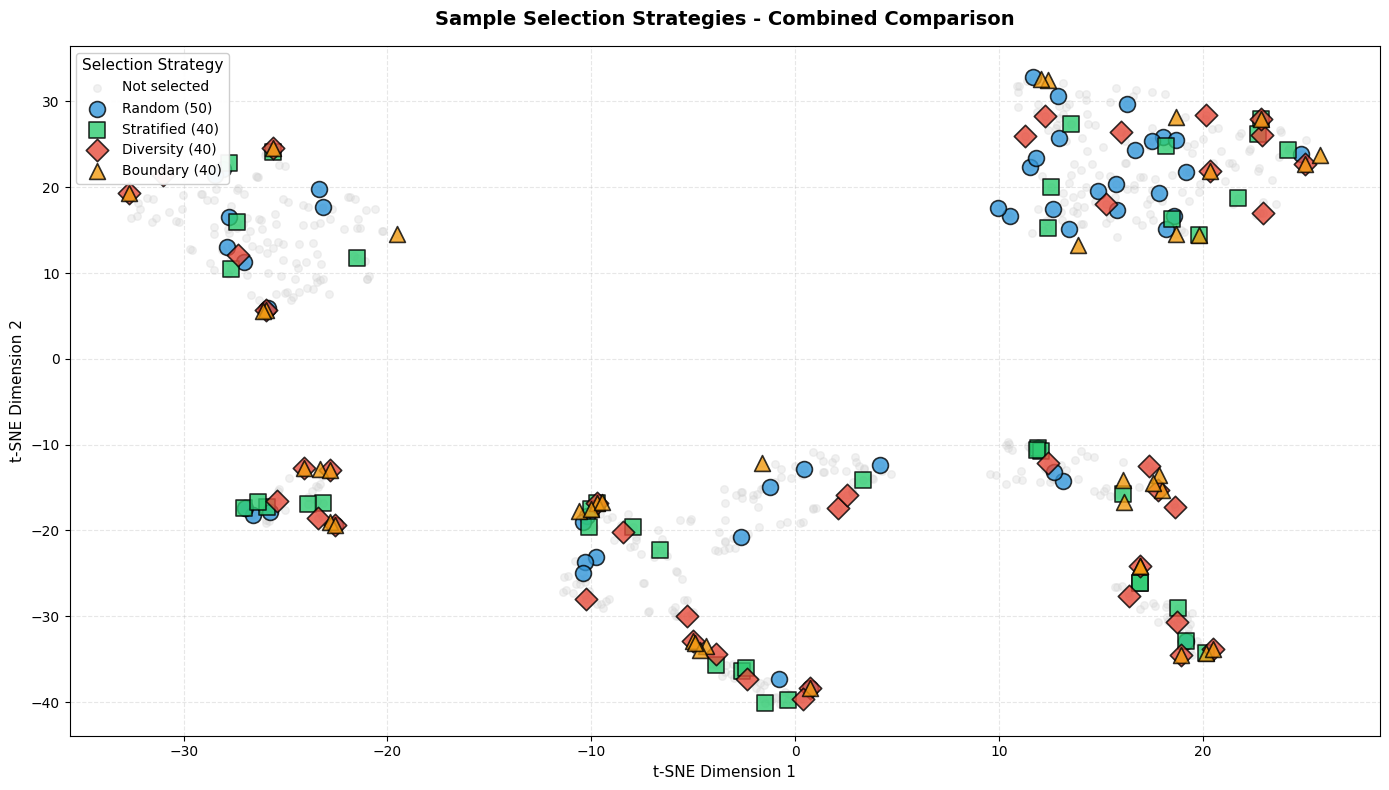


💡 Strategy Recommendations:
  • Best coverage per sample → DIVERSITY
  • Training a classifier → BOUNDARY
  • Balanced evaluation → STRATIFIED
  • Quick baseline → RANDOM


In [38]:
# Part 2: Combined comparison
fig, ax = plt.subplots(figsize=(14, 8))

# Plot all samples in light gray
ax.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1],
          c='lightgray', s=30, alpha=0.3, label='Not selected', zorder=1)

# Plot each strategy's selections with distinct markers
for strategy_name, selected_indices in strategies.items():
    style = strategy_styles[strategy_name]
    ax.scatter(tsne_embeddings[selected_indices, 0],
              tsne_embeddings[selected_indices, 1],
              c=style['color'], marker=style['marker'], s=130,
              alpha=0.8, label=f"{strategy_name} ({len(selected_indices)})",
              edgecolors='black', linewidths=1.2, zorder=2)

ax.set_title('Sample Selection Strategies - Combined Comparison',
            fontsize=14, fontweight='bold', pad=15)
ax.set_xlabel('t-SNE Dimension 1', fontsize=11)
ax.set_ylabel('t-SNE Dimension 2', fontsize=11)
ax.legend(loc='upper left', fontsize=10, framealpha=0.95, 
         title='Selection Strategy', title_fontsize=11)
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\n💡 Strategy Recommendations:")
print("  • Best coverage per sample → DIVERSITY")
print("  • Training a classifier → BOUNDARY")
print("  • Balanced evaluation → STRATIFIED")
print("  • Quick baseline → RANDOM")

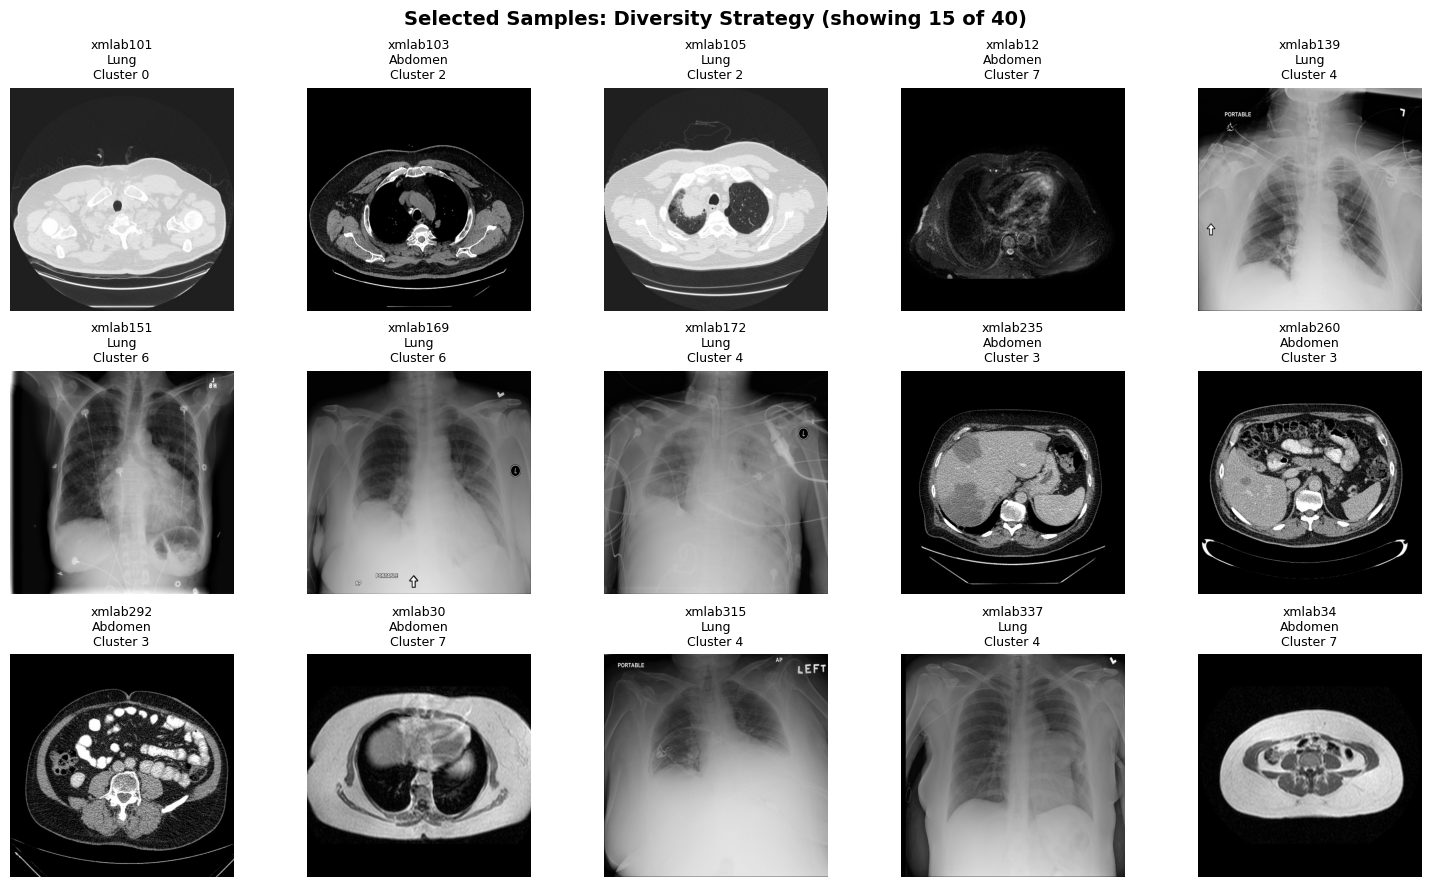


✓ These samples provide excellent coverage of the dataset's diversity!
  They span 8 different clusters
  and represent 7 anatomical locations


In [ ]:
# Display sample grid for Diversity strategy (recommended)
display_indices = diversity_indices[:min(15, len(diversity_indices))]

n_cols = 5
n_rows = (len(display_indices) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)

fig.suptitle(f'Selected Samples: Diversity Strategy (showing {len(display_indices)} of {len(diversity_indices)})',
             fontsize=14, fontweight='bold')

for idx, ax in enumerate(axes.flat):
    if idx < len(display_indices):
        img_idx = display_indices[idx]
        img_path = slake_data[img_idx]['image_path']
        img = Image.open(img_path).convert('RGB')
        ax.imshow(img)
        
        # Get cluster info
        cluster_id = kmeans_labels[img_idx]
        ax.set_title(f"{slake_data[img_idx]['sample_id']}\n{location_labels[img_idx]}\nCluster {cluster_id}",
                    fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.savefig('plots/diversity_selected_samples.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ These samples provide excellent coverage of the dataset's diversity!")
print(f"  They span {len(set(kmeans_labels[diversity_indices]))} different clusters")
print(f"  and represent {len(set([location_labels[i] for i in diversity_indices]))} anatomical locations")

## Topic Modeling - LDA vs NMF with Wordclouds

### What Are Topics?
**Topics** = recurring themes in text, represented as distributions over words.

### Why Topic Modeling for Medical Images?
- Medical images have **QA pairs** (text descriptions)
- Each **visual cluster** may have characteristic **question patterns**
- Topics help **interpret what each cluster represents**

### Two Approaches:
1. **LDA** (Latent Dirichlet Allocation) - Probabilistic, finds topic mixtures
2. **NMF** (Non-negative Matrix Factorization) - Deterministic, often more interpretable

### Enhancements:
- 🔤 **Roman character filtering** - Remove non-ASCII for cleaner topics
- ☁️ **Wordcloud visualizations** - More engaging than word lists
- ⚖️ **LDA vs NMF comparison** - See which works better

### Example Questions
- "What modality is used?" → Modality topic
- "Where is the lesion?" → Spatial/anatomical topic
- "Is there pathology?" → Diagnostic topic


In [40]:
# ENHANCEMENT: Prepare texts with Roman character filtering
from utils import filter_roman_text

cluster_qa_texts = {}

print("Preparing QA texts for topic modeling...")
print("Filtering to Roman characters only...\n")

for cluster_id in range(n_clusters_kmeans):
    cluster_mask = kmeans_labels == cluster_id
    cluster_indices = np.where(cluster_mask)[0]
    
    texts = []
    for img_idx in cluster_indices:
        for qa in slake_data[img_idx]['qa_pairs']:
            question = qa.get('question', '')
            answer = qa.get('answer', '')
            text = f"{question} {answer}"
            
            # FILTER TO ROMAN CHARACTERS ONLY
            text_filtered = filter_roman_text(text)
            if len(text_filtered.strip()) > 5:  # Only keep non-empty
                texts.append(text_filtered)
    
    cluster_qa_texts[cluster_id] = texts
    print(f"Cluster {cluster_id}: {len(texts)} QA pairs")

print("\n✓ Text preparation complete!")

Preparing QA texts for topic modeling...
Filtering to Roman characters only...

Cluster 0: 575 QA pairs
Cluster 1: 1315 QA pairs
Cluster 2: 1030 QA pairs
Cluster 3: 1412 QA pairs
Cluster 4: 949 QA pairs
Cluster 5: 314 QA pairs
Cluster 6: 1261 QA pairs
Cluster 7: 399 QA pairs

✓ Text preparation complete!


In [41]:
# Topic modeling: LDA (Latent Dirichlet Allocation)
n_topics = 3
n_top_words = 8

print("Running LDA topic modeling...")

cluster_topics_lda = {}
for cluster_id, texts in cluster_qa_texts.items():
    if len(texts) < n_topics:
        continue
    
    vectorizer = CountVectorizer(max_features=500, stop_words='english', min_df=2, max_df=0.8)
    try:
        doc_term = vectorizer.fit_transform(texts)
        lda = LatentDirichletAllocation(n_components=n_topics, random_state=42, max_iter=20)
        lda.fit(doc_term)
        
        feature_names = vectorizer.get_feature_names_out()
        topics = []
        for topic in lda.components_:
            top_words = [feature_names[i] for i in topic.argsort()[-n_top_words:][::-1]]
            topics.append(top_words)
        
        cluster_topics_lda[cluster_id] = {'topics': topics}
    except:
        pass

print(f"✓ LDA: {len(cluster_topics_lda)} clusters processed")

Running LDA topic modeling...
✓ LDA: 8 clusters processed


In [42]:
# Topic modeling: NMF + filtering
from utils import nmf_topic_modeling, filter_cluster_specific_words

print("Running NMF topic modeling...")
cluster_topics_nmf = nmf_topic_modeling(cluster_qa_texts, n_topics=n_topics, n_top_words=n_top_words)
print(f"✓ NMF: {len(cluster_topics_nmf)} clusters processed")

# ENHANCEMENT: Filter cluster-specific words
print("\nFiltering common words (appear in >30% of clusters)...")
cluster_topics_lda_filtered = filter_cluster_specific_words(cluster_topics_lda, min_cluster_specificity=0.3)
cluster_topics_nmf_filtered = filter_cluster_specific_words(cluster_topics_nmf, min_cluster_specificity=0.3)
print("✓ Filtering complete - topics are now cluster-specific!")

# Use filtered topics
cluster_topics_lda = cluster_topics_lda_filtered
cluster_topics_nmf = cluster_topics_nmf_filtered

# Display comparison
print("\n" + "="*60)
print("TOPIC COMPARISON: LDA vs NMF")
print("="*60)
for cluster_id in sorted(set(cluster_topics_lda.keys()) & set(cluster_topics_nmf.keys()))[:3]:
    print(f"\nCluster {cluster_id}:")
    print("  LDA Topics:")
    for i, words in enumerate(cluster_topics_lda[cluster_id]['topics']):
        print(f"    {i+1}. {', '.join(words[:5])}")
    print("  NMF Topics:")
    for i, words in enumerate(cluster_topics_nmf[cluster_id]['topics']):
        print(f"    {i+1}. {', '.join(words[:5])}")
print("="*60)

Running NMF topic modeling...
✓ NMF: 8 clusters processed

Filtering common words (appear in >30% of clusters)...
✓ Filtering complete - topics are now cluster-specific!

TOPIC COMPARISON: LDA vs NMF

Cluster 0:
  LDA Topics:
    1. picture, does, belong, contain, brain
    2. organ, image, head, does, picture
    3. transverse, color, appear
  NMF Topics:
    1. brain, color, mandible
    2. image, plane, yes, ct, transverse
    3. organsorgan, organs, nervous, digestive, respiratory

Cluster 1:
  LDA Topics:
    1. brain, abnormal, brian
    2. brain, mri, t2, lobe, edema
    3. t1, brain, enhancing, transverse
  NMF Topics:
    1. brain, tumor, edema, enhancing, diseases
    2. mri, t2, weighting, weighted, t1
    3. does, body, head, belong, image

Cluster 2:
  LDA Topics:
    1. picture, does, contain, yes, lung
    2. image, lung, organ, heart, liver
    3. image, belong, plane, does, body
  NMF Topics:
    1. contain, does, picture, yes, liver
    2. lung, organ, largest, image,

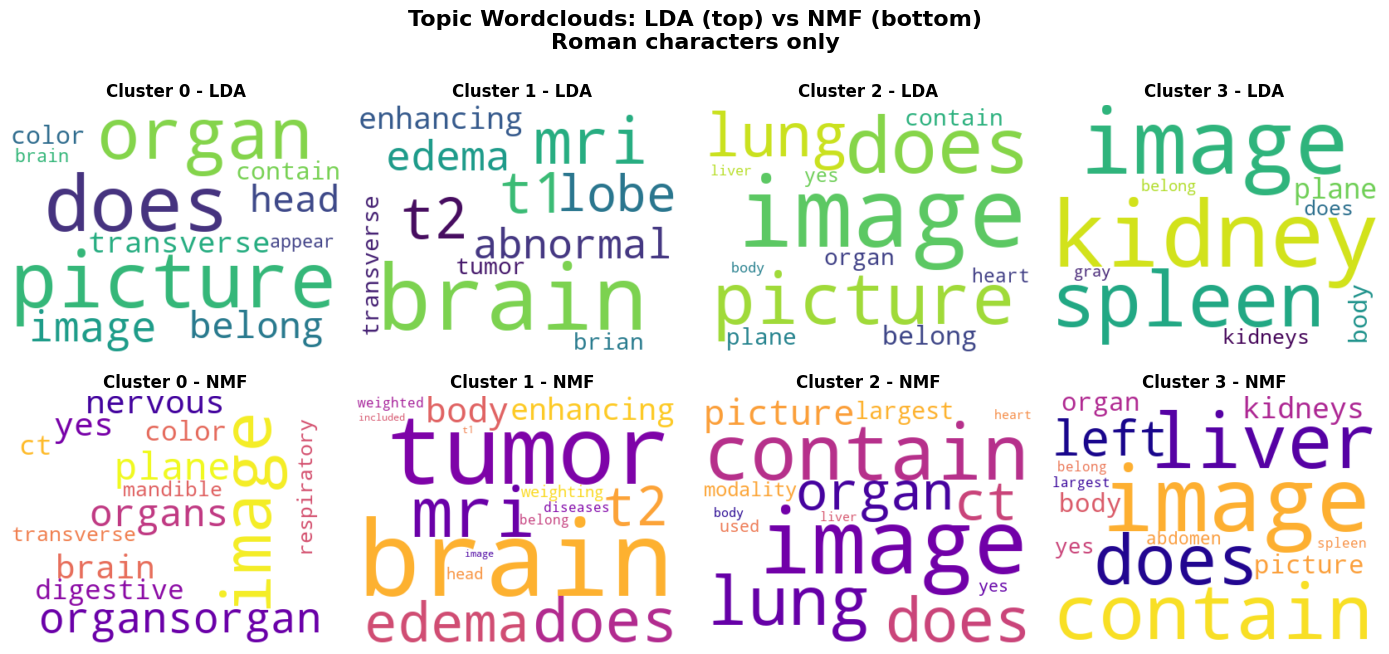


💡 LDA vs NMF Comparison:
  • LDA: Probabilistic, finds topic mixtures, may include common words
  • NMF: Deterministic, often more interpretable, sharper topic separation
  • Wordclouds: Larger words = higher importance in topic


In [ ]:
# ENHANCEMENT: Wordcloud visualizations (LDA vs NMF)
from utils import create_wordcloud_data
from wordcloud import WordCloud

n_clusters_display = min(4, len(cluster_topics_lda))

fig, axes = plt.subplots(2, n_clusters_display, figsize=(14, 7))
if n_clusters_display == 1:
    axes = axes.reshape(2, 1)

fig.suptitle('Topic Wordclouds: LDA (top) vs NMF (bottom)\nRoman characters only',
             fontsize=16, fontweight='bold')

cluster_ids_display = sorted(cluster_topics_lda.keys())[:n_clusters_display]

for idx, cluster_id in enumerate(cluster_ids_display):
    # LDA wordcloud (top row)
    ax = axes[0, idx]
    if cluster_id in cluster_topics_lda:
        word_freq = create_wordcloud_data(cluster_topics_lda, cluster_id)
        if word_freq:
            wc = WordCloud(width=400, height=300, background_color='white',
                          colormap='viridis', relative_scaling=0.5).generate_from_frequencies(word_freq)
            ax.imshow(wc, interpolation='bilinear')
    ax.set_title(f'Cluster {cluster_id} - LDA', fontsize=12, fontweight='bold')
    ax.axis('off')
    
    # NMF wordcloud (bottom row)
    ax = axes[1, idx]
    if cluster_id in cluster_topics_nmf:
        word_freq = create_wordcloud_data(cluster_topics_nmf, cluster_id)
        if word_freq:
            wc = WordCloud(width=400, height=300, background_color='white',
                          colormap='plasma', relative_scaling=0.5).generate_from_frequencies(word_freq)
            ax.imshow(wc, interpolation='bilinear')
    ax.set_title(f'Cluster {cluster_id} - NMF', fontsize=12, fontweight='bold')
    ax.axis('off')

plt.tight_layout()
plt.savefig('plots/topic_wordclouds_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n💡 LDA vs NMF Comparison:")
print("  • LDA: Probabilistic, finds topic mixtures, may include common words")
print("  • NMF: Deterministic, often more interpretable, sharper topic separation")
print("  • Wordclouds: Larger words = higher importance in topic")

### Topic Distribution in h-NNE Space

**Question:** How do text-based topics map onto the visual embedding space?

**Visualization:** h-NNE embeddings colored by cluster, annotated with dominant topic words

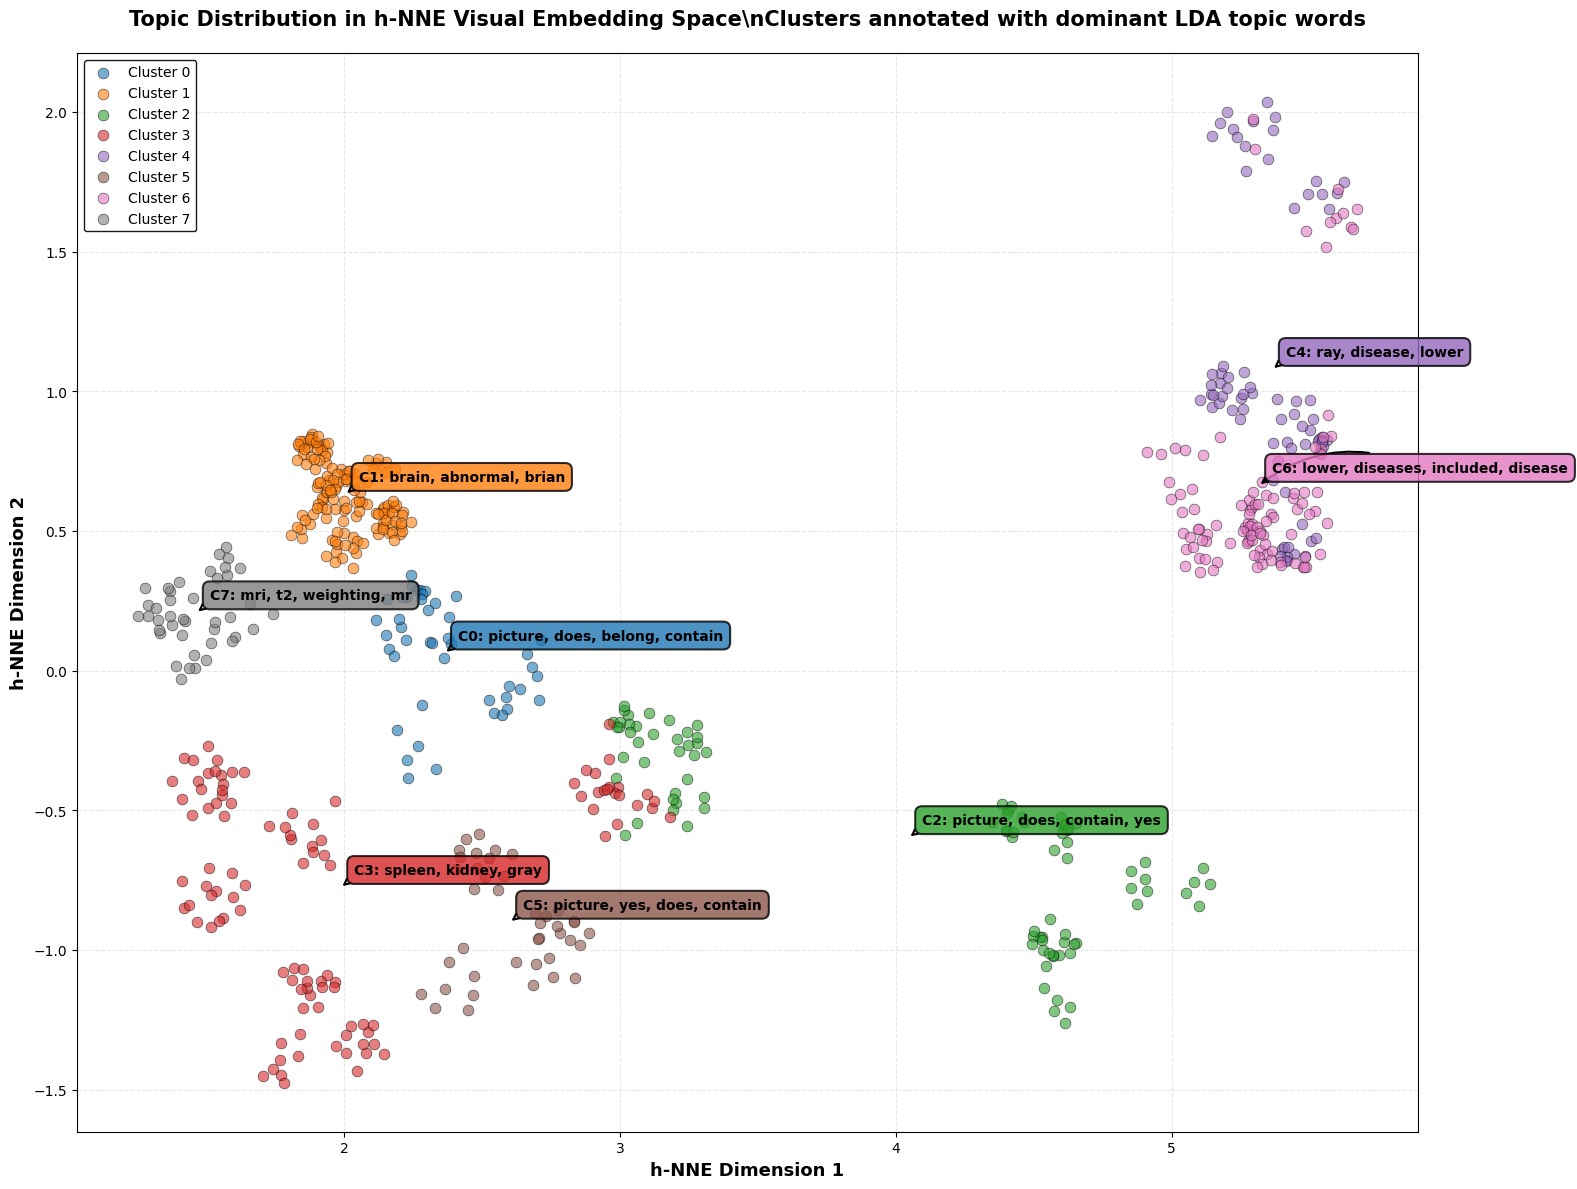

\n💡 Insights:
- Clusters with similar topics should be spatially close in h-NNE space
- Visual similarity (embedding space) vs semantic similarity (topic words)
- Helps identify which anatomical regions have similar medical terminology


In [44]:
# Visualize h-NNE embeddings colored by cluster with topic annotations
fig, ax = plt.subplots(1, 1, figsize=(16, 12))

# Create colormap for clusters
cluster_colormap = create_glasbey_colormap(n_clusters_kmeans)

# Plot each cluster
for cluster_id in range(n_clusters_kmeans):
    cluster_mask = kmeans_labels == cluster_id
    color = cluster_colormap[cluster_id]
    
    ax.scatter(hnne_embeddings[cluster_mask, 0], 
              hnne_embeddings[cluster_mask, 1],
              c=[color], s=60, alpha=0.6, 
              edgecolors='black', linewidths=0.5,
              label=f'Cluster {cluster_id}')

# Add topic annotations at cluster centroids
for cluster_id in range(n_clusters_kmeans):
    cluster_mask = kmeans_labels == cluster_id
    centroid_x = np.mean(hnne_embeddings[cluster_mask, 0])
    centroid_y = np.mean(hnne_embeddings[cluster_mask, 1])
    
    # Get top topic words for this cluster (use filtered topics)
    if cluster_id in cluster_topics_lda_filtered:
        topics = cluster_topics_lda_filtered[cluster_id]['topics']
        if len(topics) > 0:
            # Get first topic's top words
            top_words = topics[0][:4]  # Top 4 words
            topic_text = ', '.join(top_words)
            
            # Add text box with topic words
            ax.annotate(f'C{cluster_id}: {topic_text}', 
                       xy=(centroid_x, centroid_y),
                       xytext=(10, 10), textcoords='offset points',
                       bbox=dict(boxstyle='round,pad=0.5', fc=cluster_colormap[cluster_id], 
                                alpha=0.8, edgecolor='black', linewidth=1.5),
                       fontsize=10, fontweight='bold',
                       arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.3',
                                     color='black', lw=1.5))

ax.set_xlabel('h-NNE Dimension 1', fontsize=13, fontweight='bold')
ax.set_ylabel('h-NNE Dimension 2', fontsize=13, fontweight='bold')
ax.set_title('Topic Distribution in h-NNE Visual Embedding Space\\n' + 
             'Clusters annotated with dominant LDA topic words',
             fontsize=15, fontweight='bold', pad=20)
ax.legend(loc='best', framealpha=0.9, edgecolor='black')
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("\\n💡 Insights:")
print("- Clusters with similar topics should be spatially close in h-NNE space")
print("- Visual similarity (embedding space) vs semantic similarity (topic words)")
print("- Helps identify which anatomical regions have similar medical terminology")

## Outlier Detection

### Why Detect Outliers?
- **Data quality:** Identify mislabeled, corrupted, or anomalous samples
- **Distribution shift:** Find samples far from typical patterns
- **Edge cases:** Discover rare but important examples

### Three Approaches

**1. DBSCAN/HDBSCAN Noise Points**
- Samples not assigned to any dense cluster
- No extra computation

**2. Isolation Forest**
- Dedicated outlier detection algorithm
- Isolates anomalies via random partitioning
- Adjustable contamination rate

**3. Distance-Based**
- Samples far from cluster centroids
- Works with any clustering method


In [45]:
# Method 1 & 2: Already computed (DBSCAN, HDBSCAN)
# Method 3: Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_labels = iso_forest.fit_predict(X)

n_outliers_iso = list(outlier_labels).count(-1)

print(f"Outlier Detection Results:")
print(f"  DBSCAN noise points: {n_noise_dbscan}")
print(f"  HDBSCAN noise points: {n_noise_hdbscan}")
print(f"  Isolation Forest outliers (5% contamination): {n_outliers_iso}")

Outlier Detection Results:
  DBSCAN noise points: 4
  HDBSCAN noise points: 63
  Isolation Forest outliers (5% contamination): 33


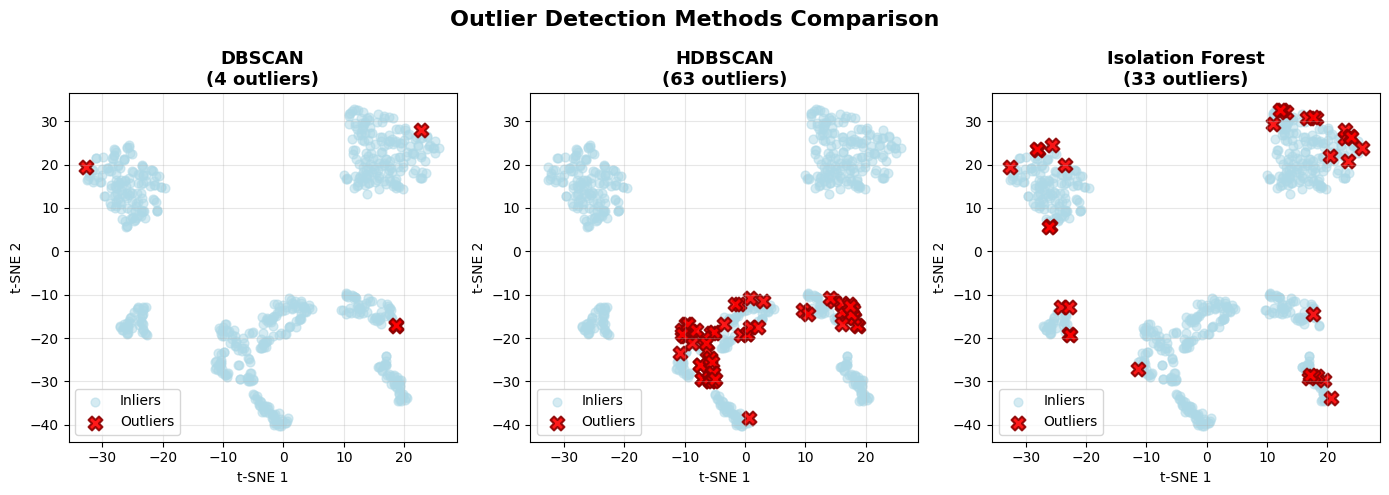


💡 When to Use Each Method:
  - DBSCAN/HDBSCAN: Quick check during clustering
  - Isolation Forest: Dedicated outlier detection, tunable sensitivity
  - Agreement across methods → high-confidence outliers
  - Disagreement → investigate those samples closely!


In [ ]:
# Visualize outliers
fig, axes = plt.subplots(1, 3, figsize=(14, 5))
fig.suptitle('Outlier Detection Methods Comparison', fontsize=16, fontweight='bold')

outlier_methods = [
    (dbscan_labels, f'DBSCAN\n({n_noise_dbscan} outliers)'),
    (hdbscan_labels, f'HDBSCAN\n({n_noise_hdbscan} outliers)'),
    (outlier_labels, f'Isolation Forest\n({n_outliers_iso} outliers)')
]

for idx, (labels, title) in enumerate(outlier_methods):
    ax = axes[idx]

    inliers = labels != -1
    outliers = labels == -1

    ax.scatter(tsne_embeddings[inliers, 0], tsne_embeddings[inliers, 1],
              c='lightblue', s=40, alpha=0.5, label='Inliers')
    ax.scatter(tsne_embeddings[outliers, 0], tsne_embeddings[outliers, 1],
              c='red', s=100, alpha=0.9, marker='X', label='Outliers',
              edgecolors='darkred', linewidths=1.5)

    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.legend(loc='best', fontsize=10)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/outlier_detection_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("When to Use Each Method:")
print("  - DBSCAN/HDBSCAN: Quick check during clustering")
print("  - Isolation Forest: Dedicated outlier detection, tunable sensitivity")
print("  - Agreement across methods → high-confidence outliers")
print("  - Disagreement → investigate those samples closely!")

## Summary & Complete Workflow

**1. Embeddings** - Compress data into semantic vectors (BiomedCLIP)

**2. Dimensionality Reduction** - Visualize high-D data in 2D
- PCA: Fast, linear, global structure
- t-SNE: Slow, non-linear, local structure
- UMAP: Fast, balanced local/global
- h-NNE: Hierarchical, fast, structure-aware

**3. Clustering** - Group similar samples
- K-means: Simple, needs k
- DBSCAN/HDBSCAN: Density-based, finds noise
- FINCH: Parameter-free, hierarchical

**4. Practical Applications**
- Duplicate detection (hashing + embedding similarity)
- Outlier detection (multiple methods)
- Sample selection (diversity + representativeness)
- Topic modeling (i.e. LDA on QA pairs)

---

### Potential Workflow

```
New Dataset Arrives
        ↓
1. Extract Embeddings (BiomedCLIP)
        ↓
2. Initial Exploration (PCA with labels)
        ↓
3. Dimensionality Reduction Comparison (runtime + visual)
        ↓
4. Clustering & Analysis
        ↓
├─ Detect duplicates → Remove/flag
├─ Identify outliers → Investigate
├─ Select representatives → Create subset
└─ Model topics → Interpret clusters
        ↓
5. Proceed to ML Model Development
```

---

### Next Steps

- **Apply to your own dataset!**
- Experiment with different parameters
- Combine insights from multiple methods
- Use selected samples for annotation/validation
- Investigate outliers and edge cases

---

### Key Takeaways

1. **No single method is best** - compare multiple approaches
2. **Visualization enables discovery** - 2D plots reveal hidden patterns
3. **Domain knowledge matters** - Interpret results in context
4. **Embeddings are powerful** - Single representation enables many tasks
5. **Hierarchical methods** (h-NNE, FINCH) provide multi-scale understanding

---

### Questions? Experiments? 
